In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
)

In [4]:

from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr, spearmanr, kruskal

## Data Merge: Computed vs. Experimental Binding

In [41]:

# 1) Load and merge computed vs. experimental data
# ------------------------------------------------
test1 = pd.read_csv("rawdat.csv")  
# Strip off any prefix in the sequence column
test1["sequence"] = test1["sequence"].str.replace("MycMax_", "", regex=False)

test2 = pd.read_csv("exp_data_all.csv")  
# Merge on the 'sequence' key, bringing in bind_avg, binding_type, etc.

print("shape of rawdat.csv is ", test1.shape)
print("shape of exp_data_all.csv is ", test2.shape)

df = pd.merge(test1, test2, on="sequence", how="left")

# Drop any sequences without experimental data
df = df.dropna()
print('shape of the merged dataframe is ',df.shape)

shape of rawdat.csv is  (272160, 10)
shape of exp_data_all.csv is  (168, 4)
shape of the merged dataframe is  (68040, 13)


In [42]:
# 1) Ensure exp keys are unique
assert test2['sequence'].is_unique, "Duplicate sequences found in exp_data_all.csv!"

# 2) See how many sequences will match
matched = test1['sequence'].isin(test2['sequence'])
print("Rows pre-merge:", len(test1))
print("Rows with a matching sequence:", matched.sum())

# 3) After merge
print("Rows post-merge (before dropna):", len(df))
print("Rows post-dropna:", len(df))

# 4) Verify added columns are present
print(set(["bind_avg","binding_type","improving"]).issubset(df.columns))


Rows pre-merge: 272160
Rows with a matching sequence: 68040
Rows post-merge (before dropna): 68040
Rows post-dropna: 68040
True


We are merging **computed energy terms** (`rawdat.csv`) with **experimental binding data** (`exp_data_all.csv`) on the `sequence` key.

- `rawdat.csv`: 272,160 rows × 10 cols → large because each sequence has hundreds of computed frames.  
- `exp_data_all.csv`: 168 rows × 4 cols → each sequence appears once with its experimental binding values.  
- After merging (`left` join on `sequence`), only rows with a matching experimental sequence remain.  
  - 68,040 rows survive → ~405 frames per experimental sequence (168 total).  
  - Shape = 68,040 rows × 13 cols (10 computed + 3 experimental).  

**Sanity checks performed:**
1. Experimental keys are unique (no duplicates).  
2. 68,040 out of 272,160 raw rows matched experimental sequences.  
3. After dropping missing values, row count stays the same (all matched rows had experimental data).  
4. Verified new columns (`bind_avg`, `binding_type`, `improving`) exist in the merged dataframe.

Final dataframe contains **only rows with both computed features and experimental annotations.**


In [43]:
df

,sequence,run,VDWAALS,EEL,EGB,ESURF,HB Energy,Hydrophobic Energy,Pi-Pi Energy,Delta_Entropy,bind_avg,binding_type,improving
1620,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-236.997,-1869.660,1823.216,-35.292,-2.590101,-156.445725,-4.282747,-24.750849,0.166339,1.0,0.0
1621,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-218.620,-1850.331,1807.831,-32.521,-2.977171,-142.709472,-7.240534,-25.235404,0.166339,1.0,0.0
1622,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-232.611,-1878.075,1834.181,-34.170,-3.105868,-145.088977,-8.856276,-25.124940,0.166339,1.0,0.0
1623,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-203.677,-1870.595,1823.641,-32.402,-3.414769,-150.961716,-5.338670,-23.079573,0.166339,1.0,0.0
1624,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-212.279,-1864.730,1820.462,-31.858,-3.571942,-146.583284,-7.171679,-22.812241,0.166339,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262435,TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC,20,-202.283,-1879.826,1832.379,-32.929,-14.839736,-146.069103,-8.120329,-22.481285,-0.157256,0.0,1.0
262436,TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC,20,-194.599,-1894.990,1847.186,-32.980,-12.082321,-142.591876,-9.019913,-22.615403,-0.157256,0.0,1.0
262437,TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC,20,-201.025,-1877.378,1832.770,-30.974,-11.361504,-133.609931,-1.746638,-23.680611,-0.157256,0.0,1.0
262438,TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC,20,-208.522,-1861.670,1816.586,-32.079,-16.003776,-139.845659,-0.000942,-21.846114,-0.157256,0.0,1.0


In [45]:
seq_df = (df.groupby('sequence', as_index=False)
            .agg({**{c:'mean' for c in energy_terms}, 'bind_avg':'first','binding_type':'first'}))
# print(seq_df)
seq_df


,sequence,VDWAALS,EEL,EGB,ESURF,HB Energy,Hydrophobic Energy,Pi-Pi Energy,Delta_Entropy,bind_avg,binding_type
0,AACCACTCGACTGACCTCGTGGTCAAATTCCTTACT,-208.983581,-1885.158533,1838.543830,-31.902756,-13.493363,-139.298455,-2.702283,-22.434960,1.472119,2.0
1,AACCTAAAACAAAAAATCTATTATCTGATTGCAGGT,-199.695180,-1916.121546,1867.262391,-31.697067,-3.493487,-135.343286,-4.578578,-21.588544,-0.078805,0.0
2,AATCAGAGAAACTCACACGCGGAGTTTTAAATAATG,-216.069286,-1897.824078,1850.505922,-32.638059,-3.377744,-146.192580,-2.170924,-22.710628,2.035660,2.0
3,ACATTTTTGGCCTGCAACGTGGGGACTCAAGAAGCA,-213.433321,-1890.300540,1841.822080,-32.890844,-3.531171,-144.712730,-3.390365,-22.504559,0.614097,1.0
4,ACCAAAAAAAAAAAAAAAAAAAAAACTCATCCCCAA,-189.877964,-1888.806512,1841.946705,-30.225843,-13.833728,-123.632697,-3.379164,-21.755520,0.180426,1.0
5,AGGTAGTTTTCATAGTTTTTTTTTTTTTAACTTTTT,-176.800115,-1886.254644,1839.415006,-28.115985,-3.002615,-113.820215,-3.508404,-19.168511,-0.280619,0.0
6,ATCTCCTGGGGCGACCACGAGGTCACCCGTCCAGGT,-208.822638,-1905.242805,1856.083727,-31.991943,-14.923427,-144.297819,-1.796078,-22.728763,1.524243,2.0
7,CAAAGGATCATGAAGATTGAGGTTTCCAGACCTTGC,-198.854215,-1907.820047,1859.382146,-31.315249,-14.001872,-132.797731,-3.378300,-21.700019,0.092349,1.0
8,CACTCCACTCCAGTTCACTCTATTCAGTTCCACTCC,-201.235622,-1905.895070,1857.302301,-32.219376,-3.622301,-134.575619,-3.886507,-22.727847,-0.731150,0.0
9,CAGCCTGTTGTTGGCCAGATGGTCTGGGGTGAAACT,-210.060437,-1893.115960,1845.937843,-32.661397,-14.561495,-139.240009,-3.469916,-22.572715,-0.189569,0.0


We grouped by sequence and averaged computed energy terms across simulation frames, collapsing ~405 rows per sequence into a single row. The resulting dataframe has one entry per sequence with mean computed energies and corresponding experimental binding data.

For each sequence:
- Every energy term column (like VDWALAS, EEL, EGB, etc.) → take the mean across all frames.
- bind_avg → take the first value (since it’s the same for all rows anyway).
- binding_type → take the first value.
Essentially: compress 405 frame rows → 1 row per sequence.

We did this just for checks purposes. Now in the next two cells we're doing more sanity checks to get a feel for what our data looks like.

In [46]:
# labels unique?
assert test2['sequence'].is_unique

# how many frames per sequence?
test1['sequence'].value_counts().describe()


count     168.0
mean     1620.0
std         0.0
min      1620.0
25%      1620.0
50%      1620.0
75%      1620.0
max      1620.0
Name: sequence, dtype: float64

This counts how many times each sequence appears in rawdat.csv.

Output:
- count = 168 → there are 168 unique sequences.
- mean = std = min = max = 1620 → every sequence appears exactly 1620 times.
- This matches the Molecular Dynamics simulation setup: ~1620 frames (snapshots) per sequence.

In [47]:
for t in energy_terms:
    df[f'{t}_z_within'] = df.groupby('sequence')[t].transform(lambda s: (s - s.mean())/s.std(ddof=0))
    print(df[f'{t}_z_within'])


1620     -2.098662
1621     -1.051172
1622     -1.848660
1623     -0.199419
1624     -0.689734
            ...   
262435    0.244156
262436    0.664885
262437    0.313037
262438   -0.097453
262439    0.877111
Name: VDWAALS_z_within, Length: 68040, dtype: float64
1620      1.000877
1621      1.488413
1622      0.788625
1623      0.977294
1624      1.125227
            ...   
262435    0.243135
262436   -0.179567
262437    0.311373
262438    0.749239
262439    0.753978
Name: EEL_z_within, Length: 68040, dtype: float64
1620     -0.968771
1621     -1.383411
1622     -0.673254
1623     -0.957317
1624     -1.042994
            ...   
262435   -0.284102
262436    0.159236
262437   -0.272395
262438   -0.756962
262439   -0.760525
Name: EGB_z_within, Length: 68040, dtype: float64
1620     -1.871198
1621     -0.591170
1622     -1.352904
1623     -0.536200
1624     -0.284906
            ...   
262435   -0.411765
262436   -0.435191
262437    0.486227
262438   -0.021334
262439    0.189499
Name: ESUR

Next, we compute **within-sequence z-scores** for each energy term:
- Group by `sequence`.
- Subtract the sequence mean and divide by its standard deviation.
- Produces columns like `Hydrophobic Energy_z_within`, `Pi-Pi Energy_z_within`, etc.
- These represent **frame-to-frame fluctuations** relative to the sequence’s baseline (mean = 0, variance = 1 within each sequence).

This captures dynamic variability within sequences, complementing the sequence-level averages.

This can potentially be used as additional ML features (to encode dynamic variation) but we are not worrying about that now because our plan is to train our ML models through different approaches of 1) training on the whole time series data, 2) training it on averages of whole time series data which entails averaging throught he 1620 frames per sequence, and 3) some mix of batch averaging.

You will see that in further sections when we go through our ML strategy

## Analysis Plots

In [48]:
# 2) Function to compute η² effect size from Kruskal–Wallis H
# -------------------------------------------------------------
def eta_squared(kruskal_stat, num_groups, total_size):
    """
    Eta-squared estimate of effect size from a KW H-statistic.
      η² = (H - k + 1) / (N - k)
    where k = number of groups, N = total sample size.
    """
    return (kruskal_stat - num_groups + 1) / (total_size - num_groups)

In [ ]:
def plot_term_panel(df, term, label_col="bind_avg", category_col="binding_type",
                    bins=25, figsize=(16, 10), dpi=200, save=True):
    """
    Makes a single 'mega-panel' figure for one energy term:
      [Top-left]  Histogram of standardized values
      [Top-right] Scatter vs experimental ΔΔG + Pearson/Spearman r
      [Bottom-left] Boxplot by binding_type (0/1/2)
      [Bottom-right] Text stats: KW H, p, η², sample sizes
    """
    # Standardize this term
    col_std = f"{term} (std)"
    x = df[term].to_numpy()
    x_std = (x - np.nanmean(x)) / np.nanstd(x)
    y = df[label_col].to_numpy()

    # Prepare groups for KW on raw values
    groups = [df[df[category_col] == bt][term].dropna().to_numpy()
              for bt in sorted(df[category_col].dropna().unique())]
    # Defensive: need at least 2 groups with data
    valid_groups = [g for g in groups if len(g) > 1]
    if len(valid_groups) >= 2:
        H, p_kw = kruskal(*valid_groups)
        eta2 = eta_squared(H, len(valid_groups), len(df))
    else:
        H, p_kw, eta2 = np.nan, np.nan, np.nan

    # Correlations on standardized values (finite only)
    mask = np.isfinite(x_std) & np.isfinite(y)
    if mask.sum() >= 3:
        r_p, _ = pearsonr(x_std[mask], y[mask])
        r_s, _ = spearmanr(x_std[mask], y[mask])
    else:
        r_p, r_s = np.nan, np.nan

    # Figure layout
    plt.rcParams.update({
        "axes.labelsize": 13,
        "axes.titlesize": 14,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = GridSpec(2, 2, figure=fig, width_ratios=[1,1], height_ratios=[1,1], hspace=0.35, wspace=0.25)

    # 1) Histogram (standardized)
    ax1 = fig.add_subplot(gs[0,0])
    ax1.hist(x_std[np.isfinite(x_std)], bins=bins)
    ax1.set_title(f"Standardized {term}: dist")
    ax1.set_xlabel(f"{term} (std)")
    ax1.set_ylabel("Count")

    # 2) Scatter vs bind_avg with correlations
    ax2 = fig.add_subplot(gs[0,1])
    ax2.scatter(x_std[mask], y[mask], alpha=0.6, s=12)
    ax2.set_title(f"{term} vs Experimental ΔΔG")
    ax2.set_xlabel(f"{term} (std)")
    ax2.set_ylabel("ΔΔG (bind_avg)")
    txt = f"Pearson r = {r_p:.2f}\nSpearman r = {r_s:.2f}"
    ax2.text(0.02, 0.98, txt, transform=ax2.transAxes, va="top", ha="left",
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

    # 3) Boxplot by binding_type (uses raw standardized values for display)
    ax3 = fig.add_subplot(gs[1,0])
    cats = sorted(df[category_col].dropna().unique())
    data_by_cat = [x_std[df[category_col] == c] for c in cats]
    ax3.boxplot(data_by_cat, labels=[str(c) for c in cats], showfliers=False)
    ax3.set_title(f"{term} by Binding Category")
    ax3.set_xlabel("Binding Category (0=weak,1=med,2=strong)")
    ax3.set_ylabel(f"{term} (std)")

    # 4) Text panel: stats summary
    ax4 = fig.add_subplot(gs[1,1])
    ax4.axis("off")
    sizes = [len(df[df[category_col] == c]) for c in cats]
    stats_text = (
        f"KW H = {H:.2f}\n"
        f"KW p = {p_kw:.3e}\n"
        f"η² = {eta2:.3f}\n\n"
        f"Groups: {cats}\n"
        f"Sizes:  {sizes}\n"
        f"Total N = {len(df)}"
    )
    ax4.text(0.0, 1.0, stats_text, va="top", ha="left", fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec="lightgray"))

    # Super title
    fig.suptitle(f"Mega-panel: {term}", y=0.98, fontsize=16)

    if save:
        outname = f"panel_{term.replace(' ','_').replace('/','-')}.png"
        fig.savefig(outname, bbox_inches="tight")
        print(f"Saved: {outname}")

    plt.show()




Saved: panel_VDWAALS.png


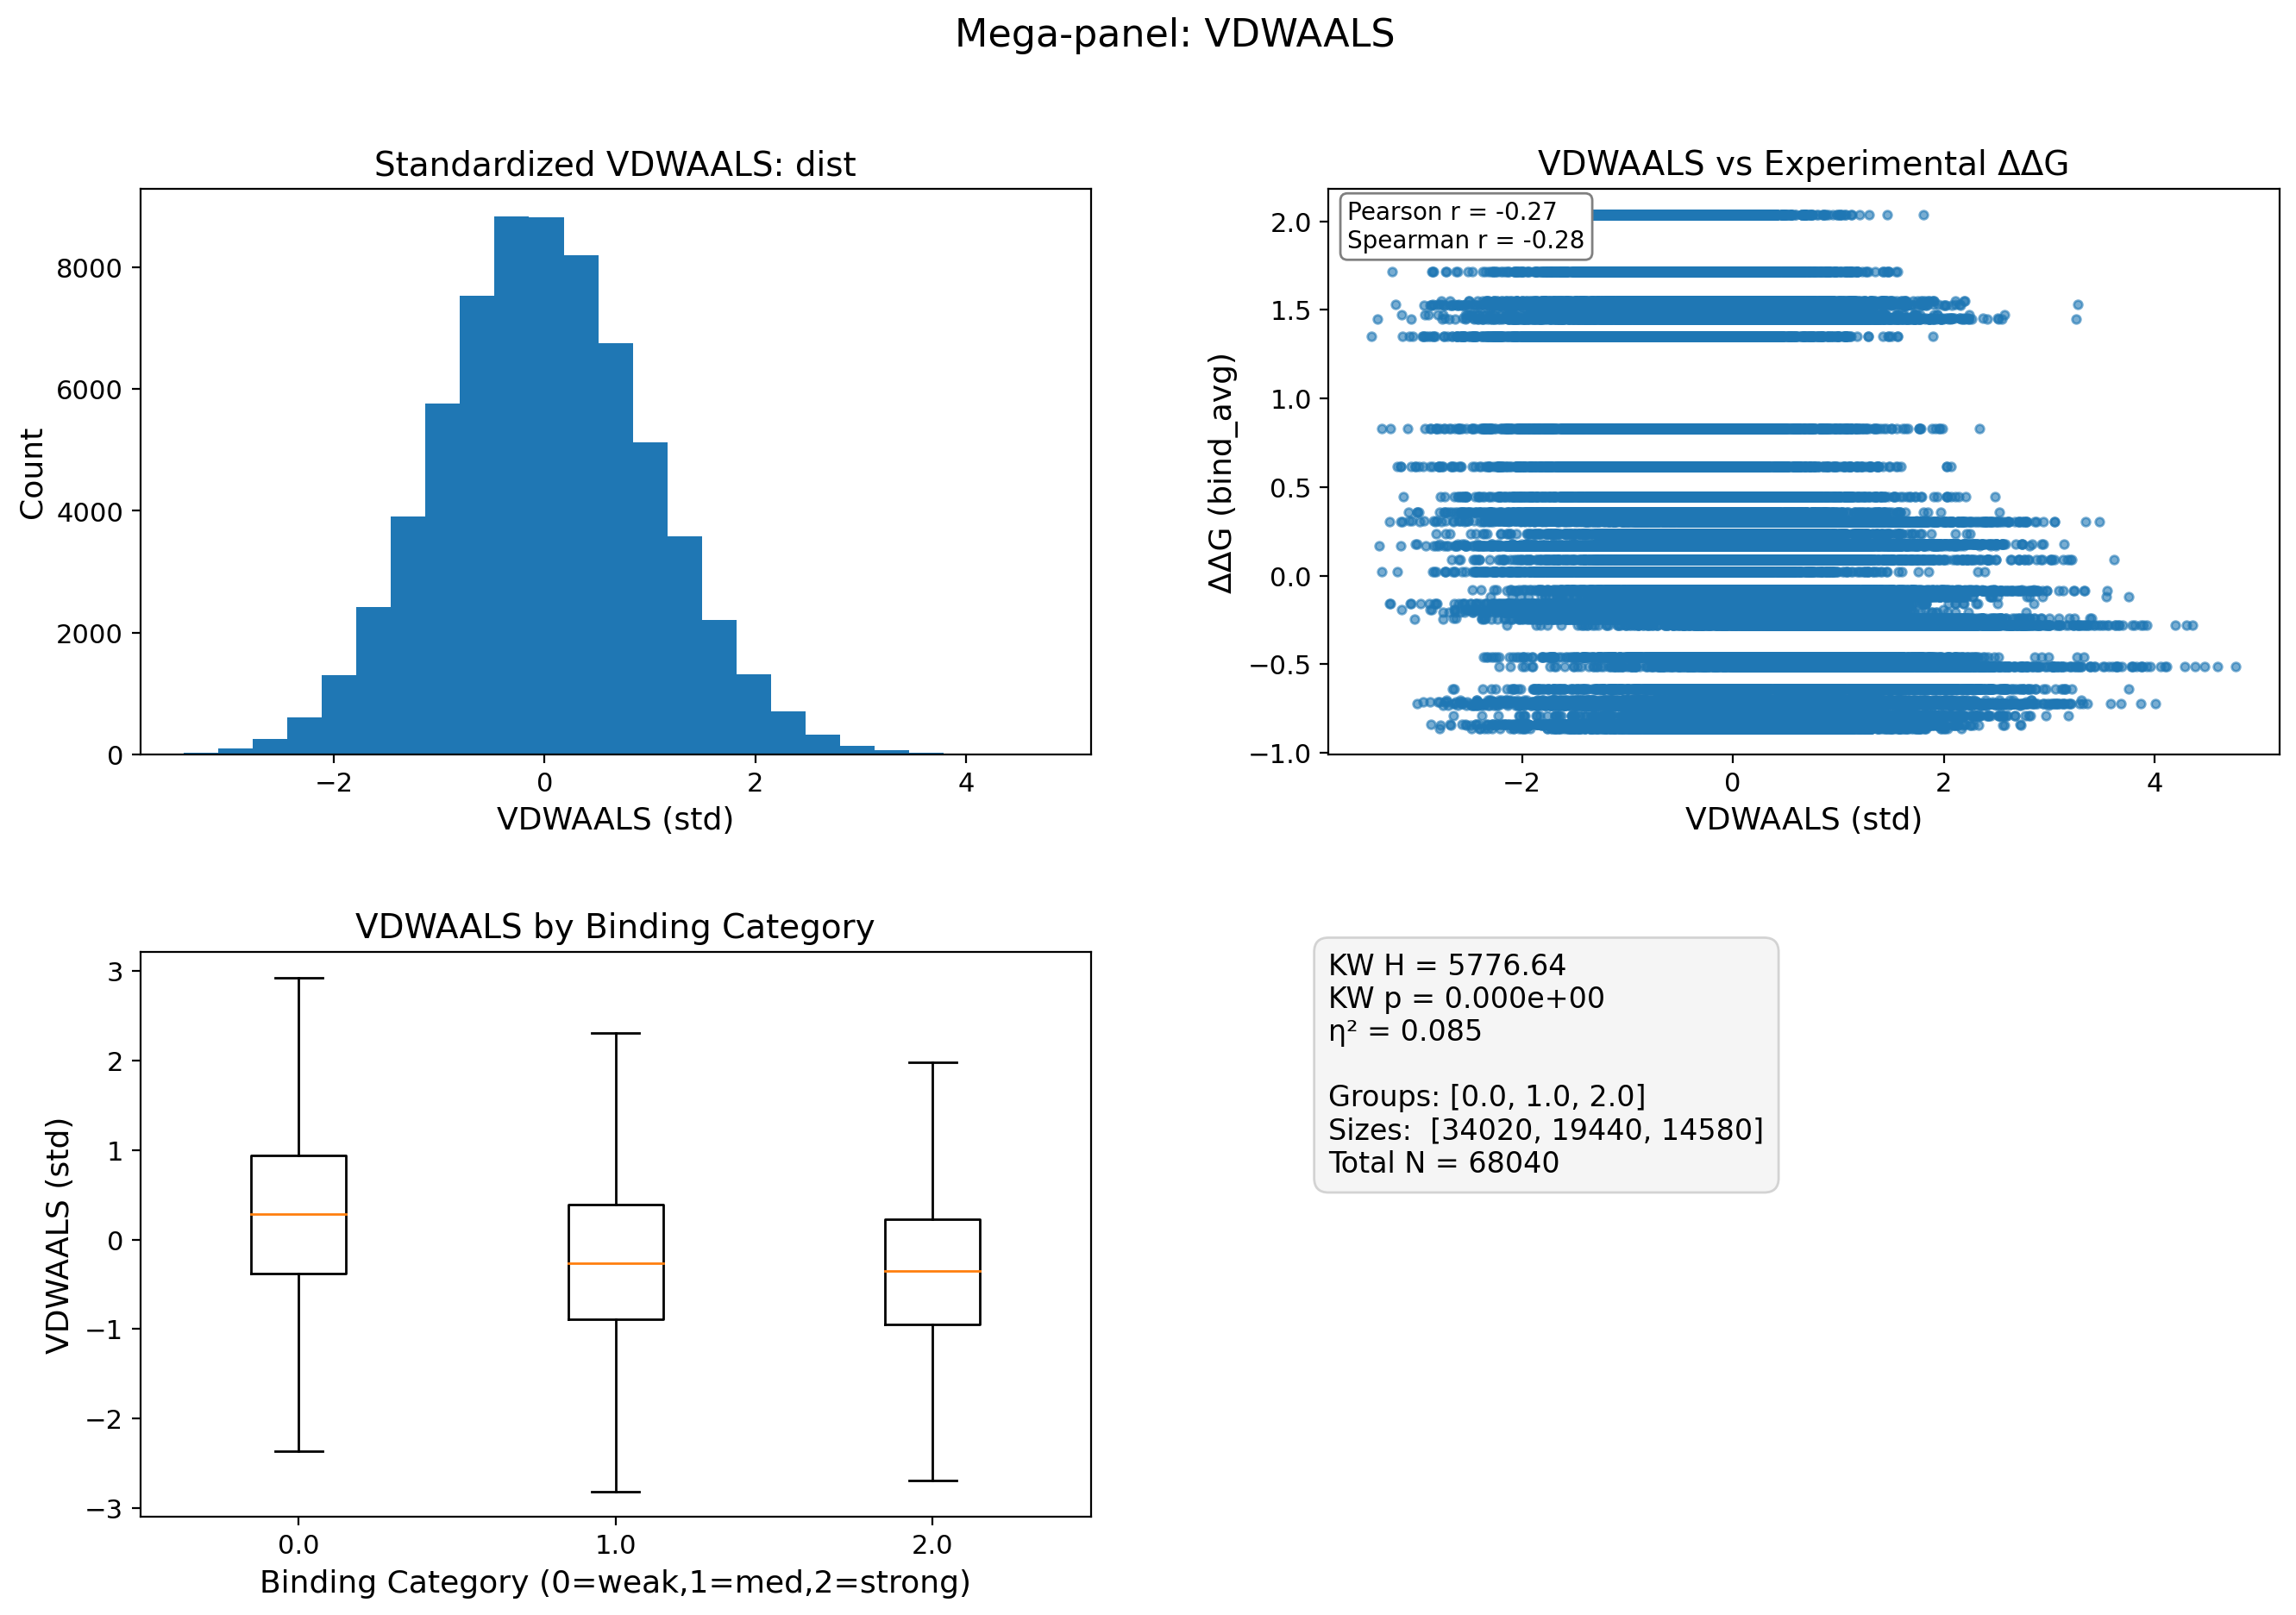

Saved: panel_EEL.png


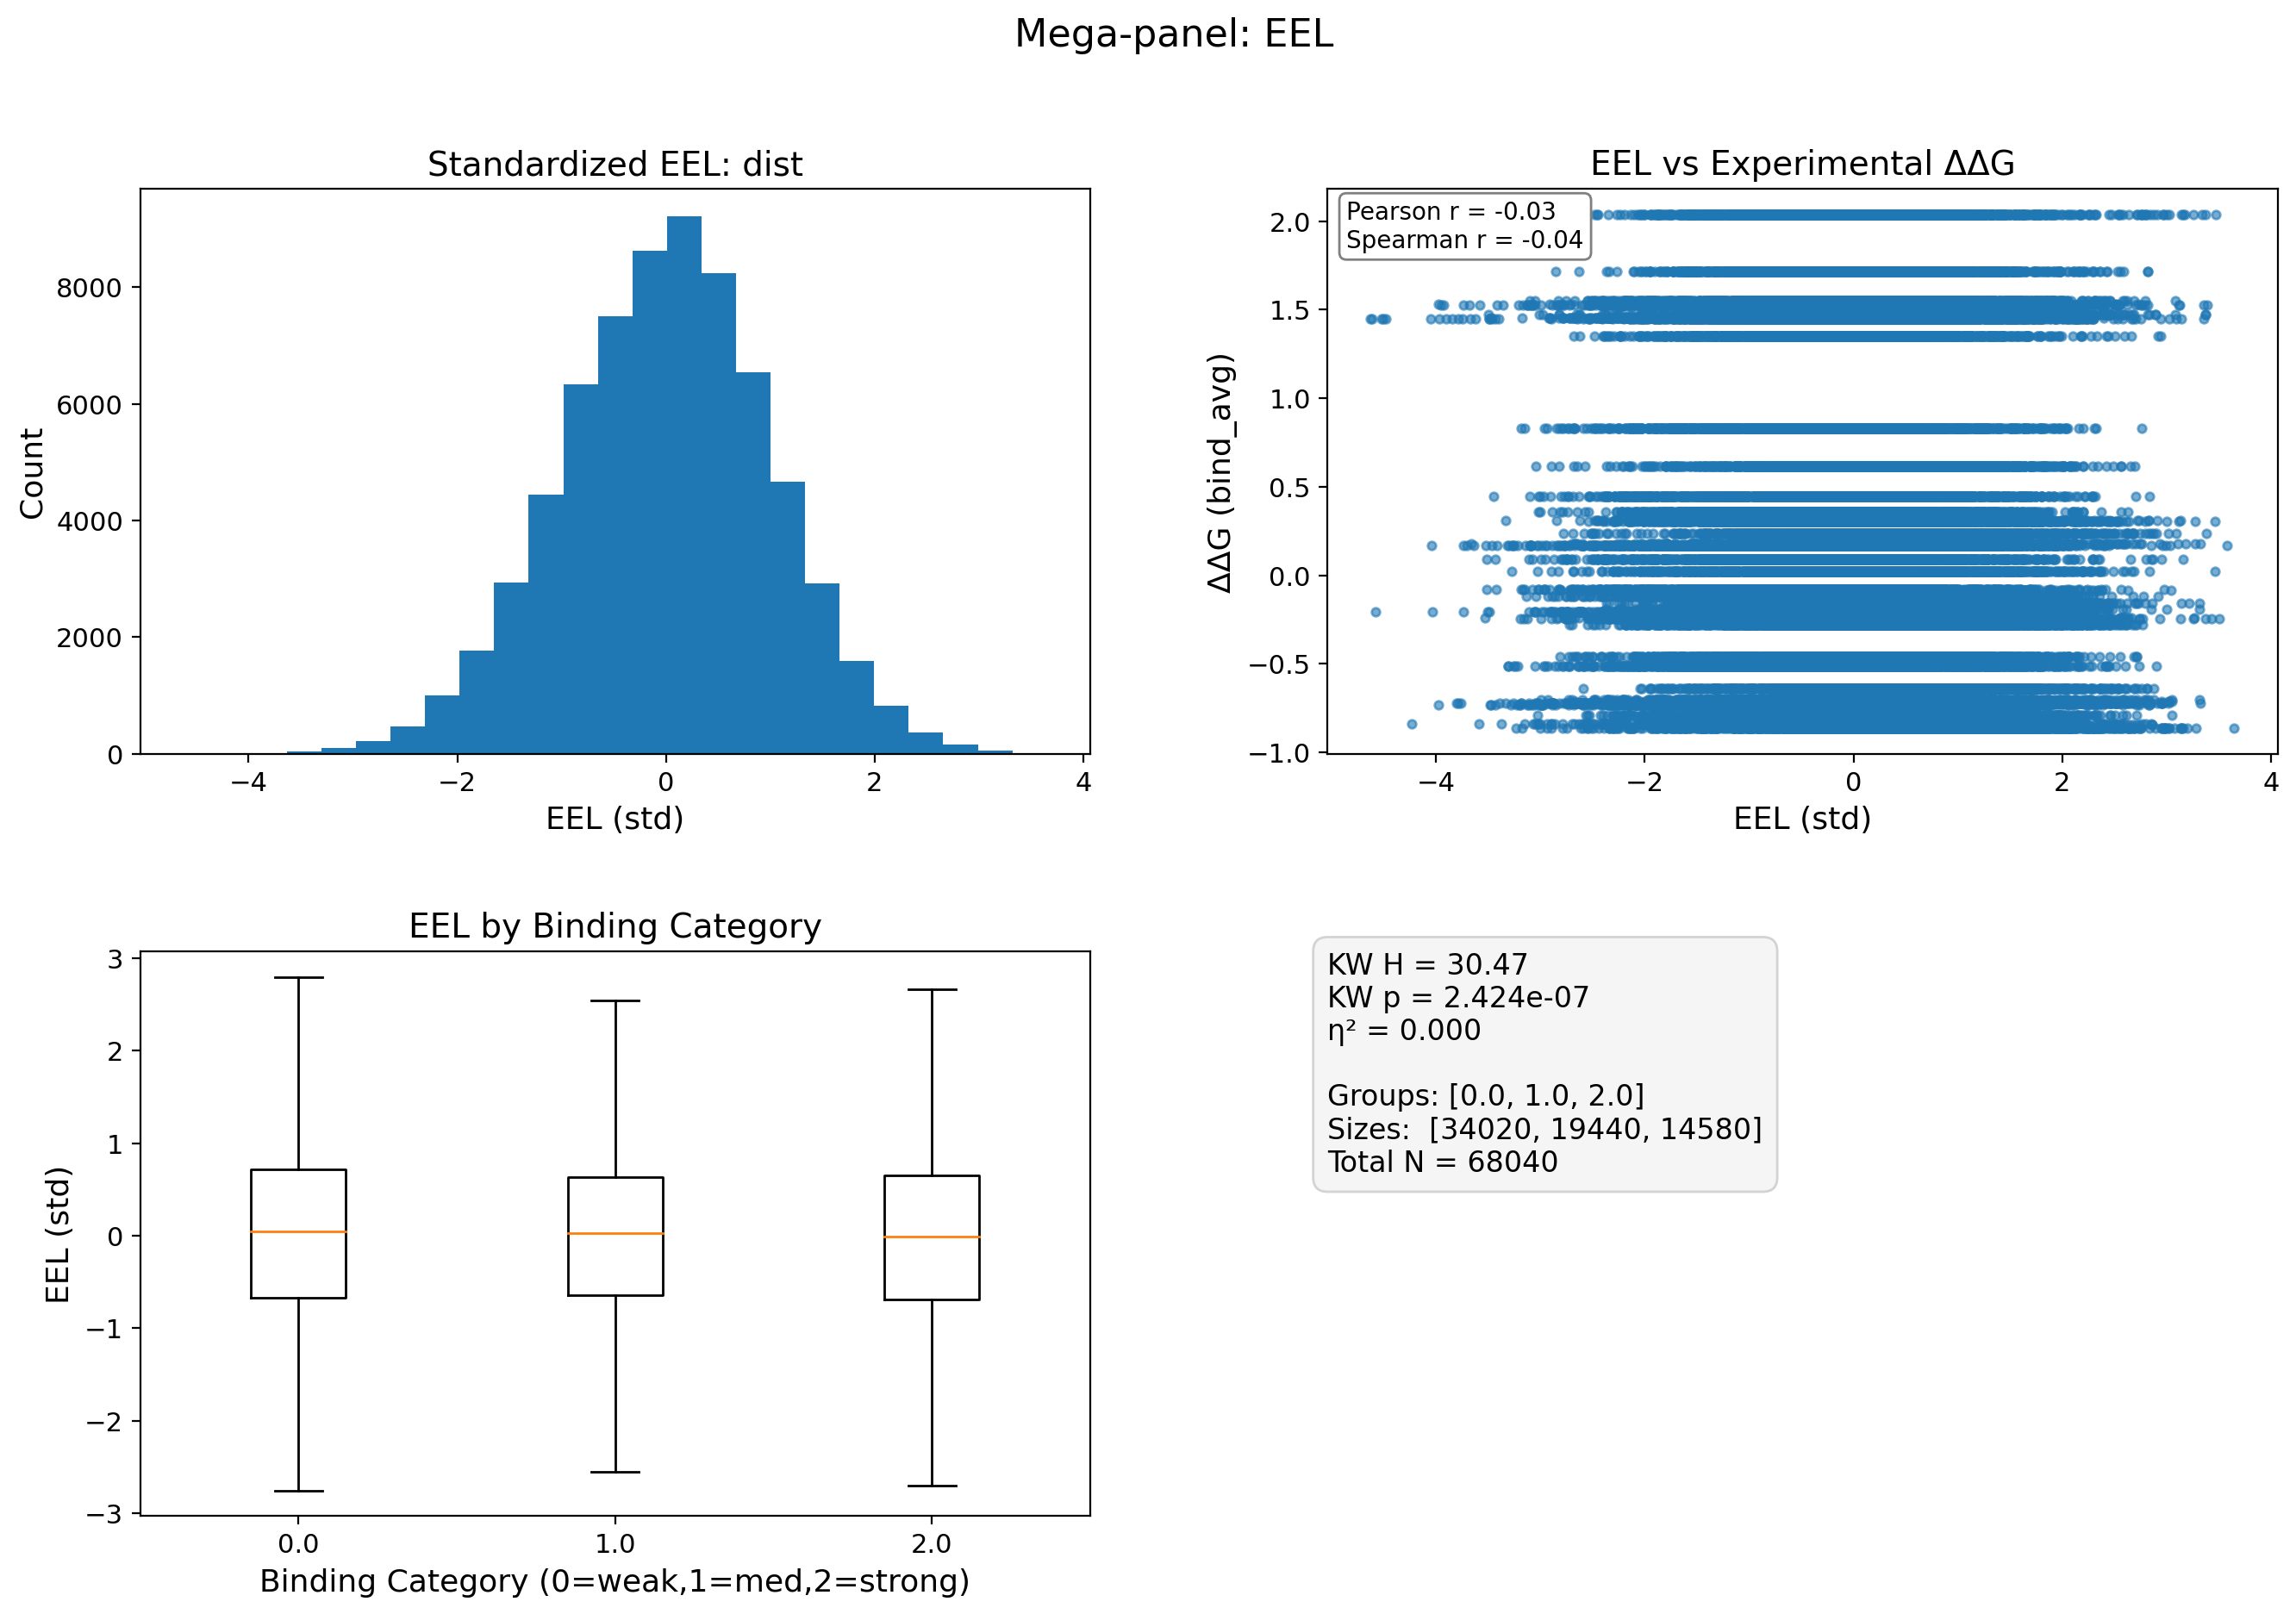

Saved: panel_EGB.png


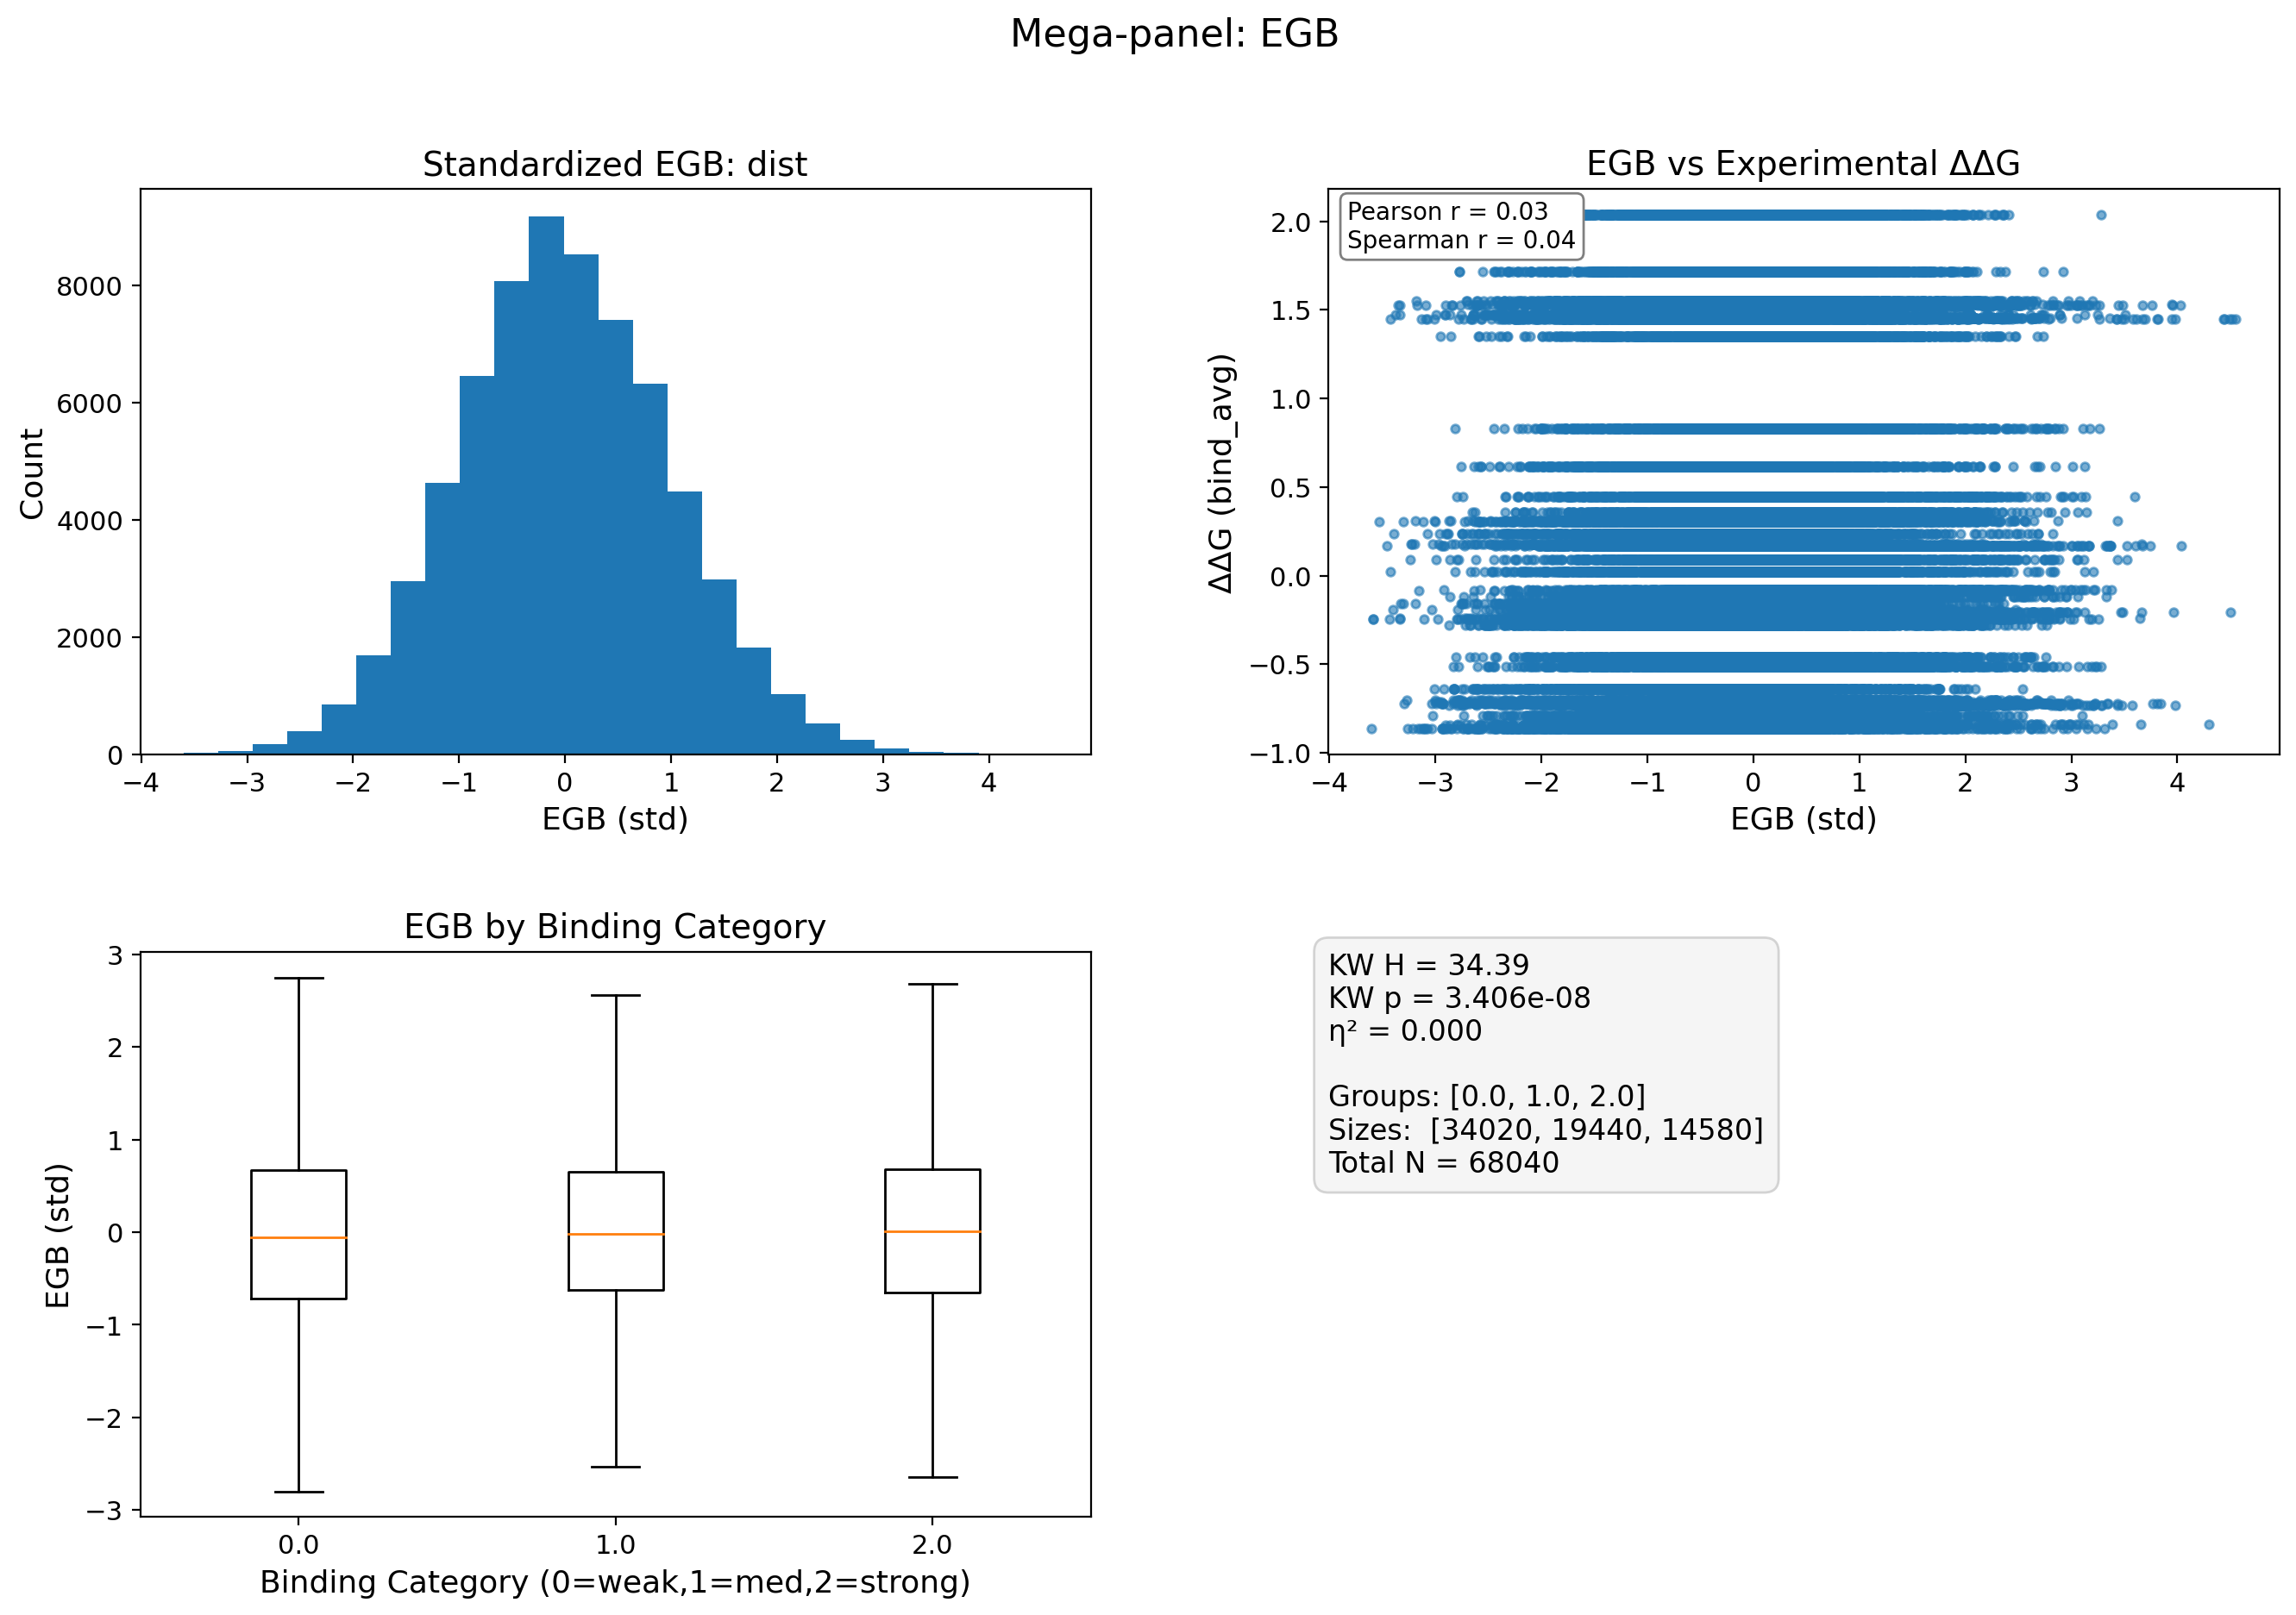

Saved: panel_ESURF.png


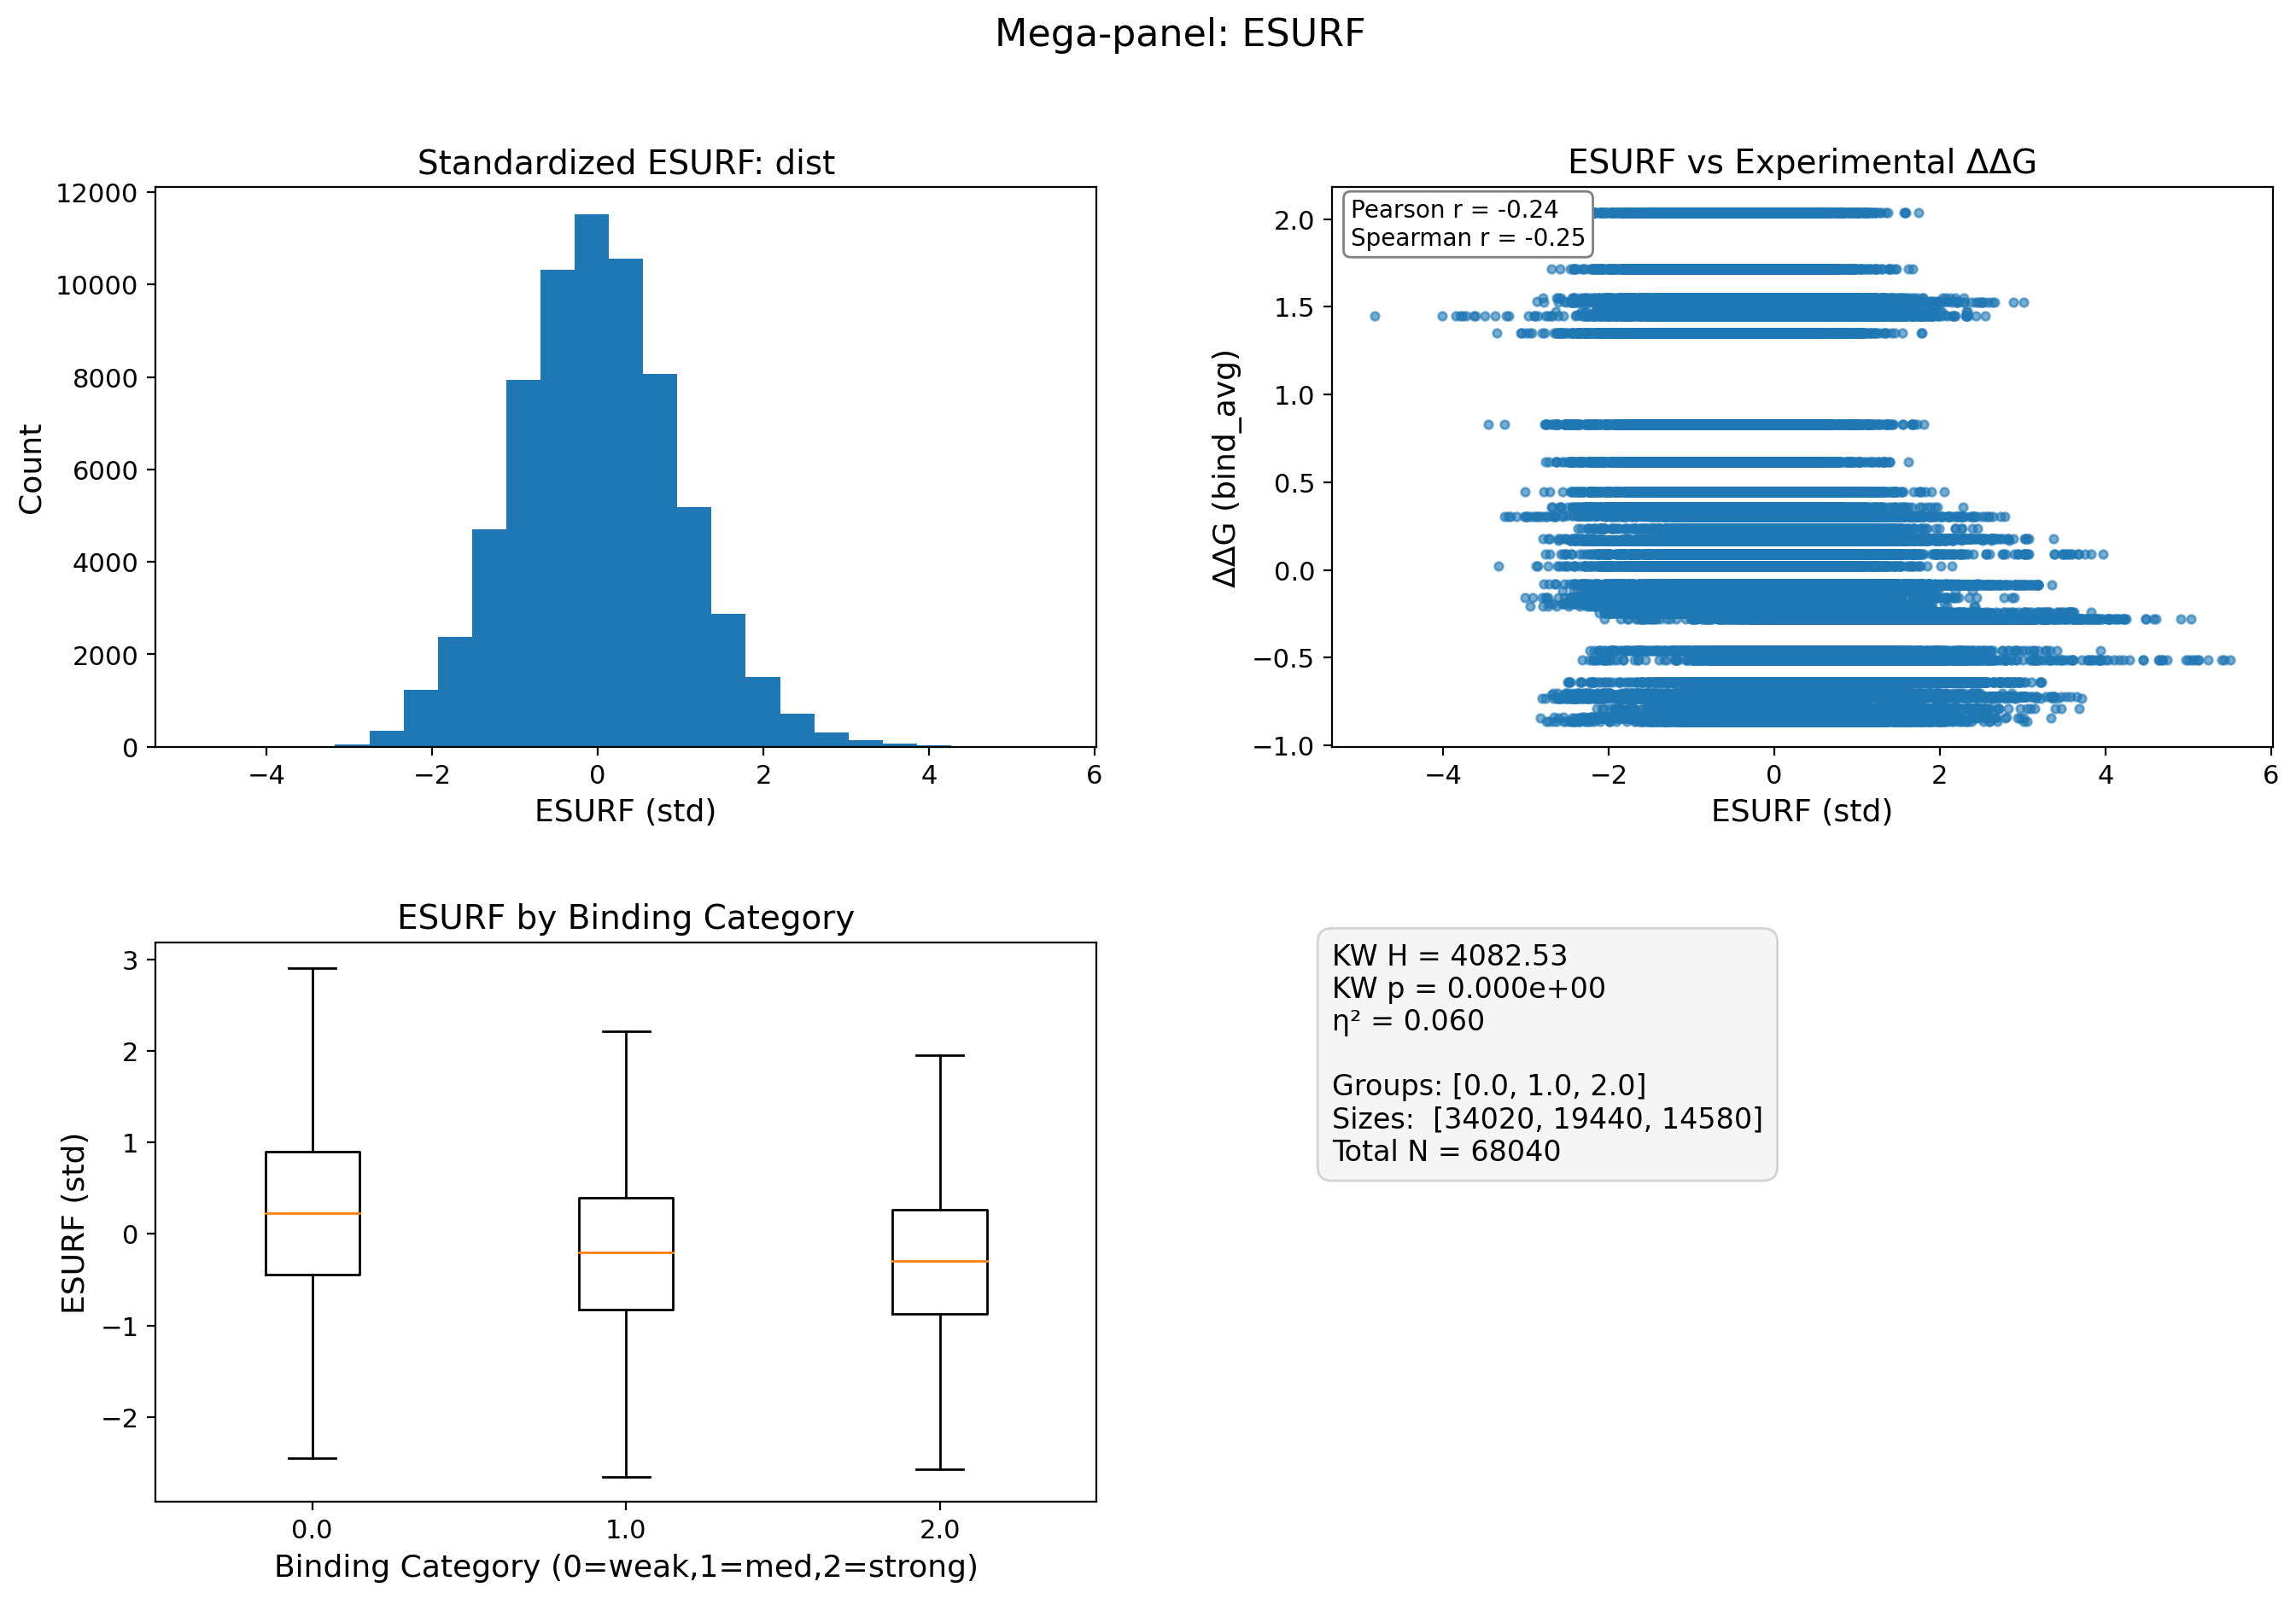

Saved: panel_HB_Energy.png


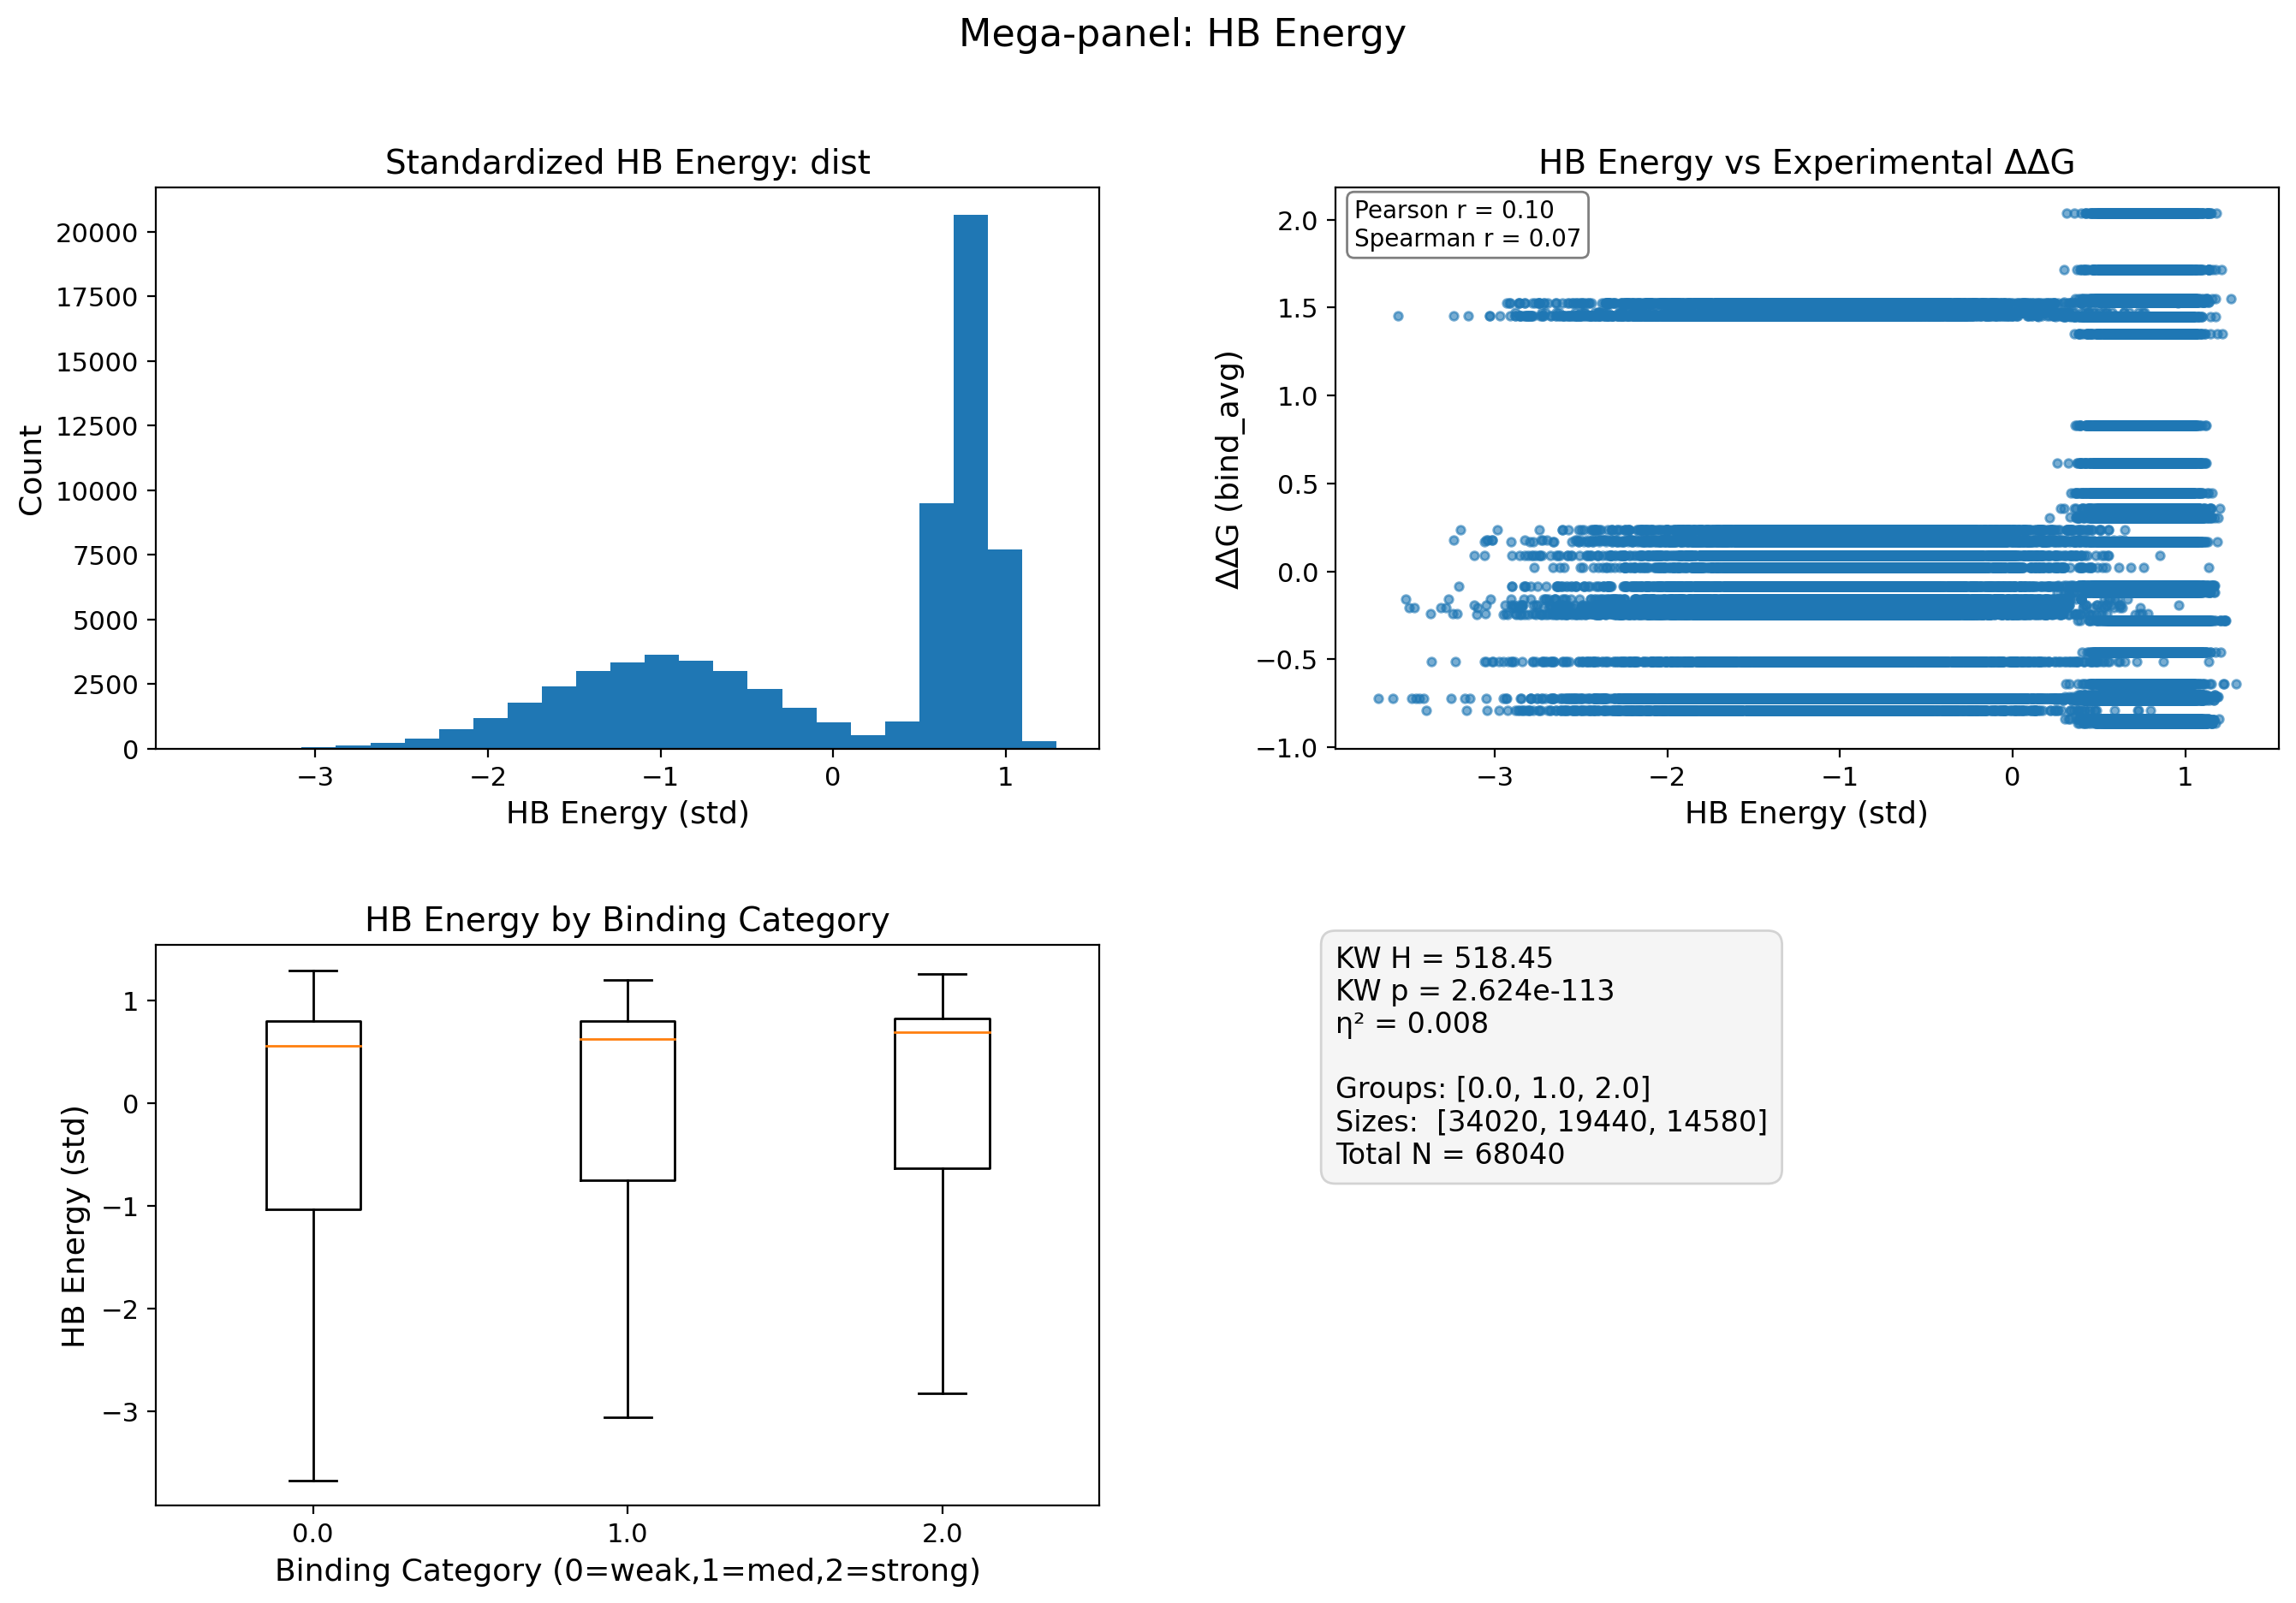

Saved: panel_Hydrophobic_Energy.png


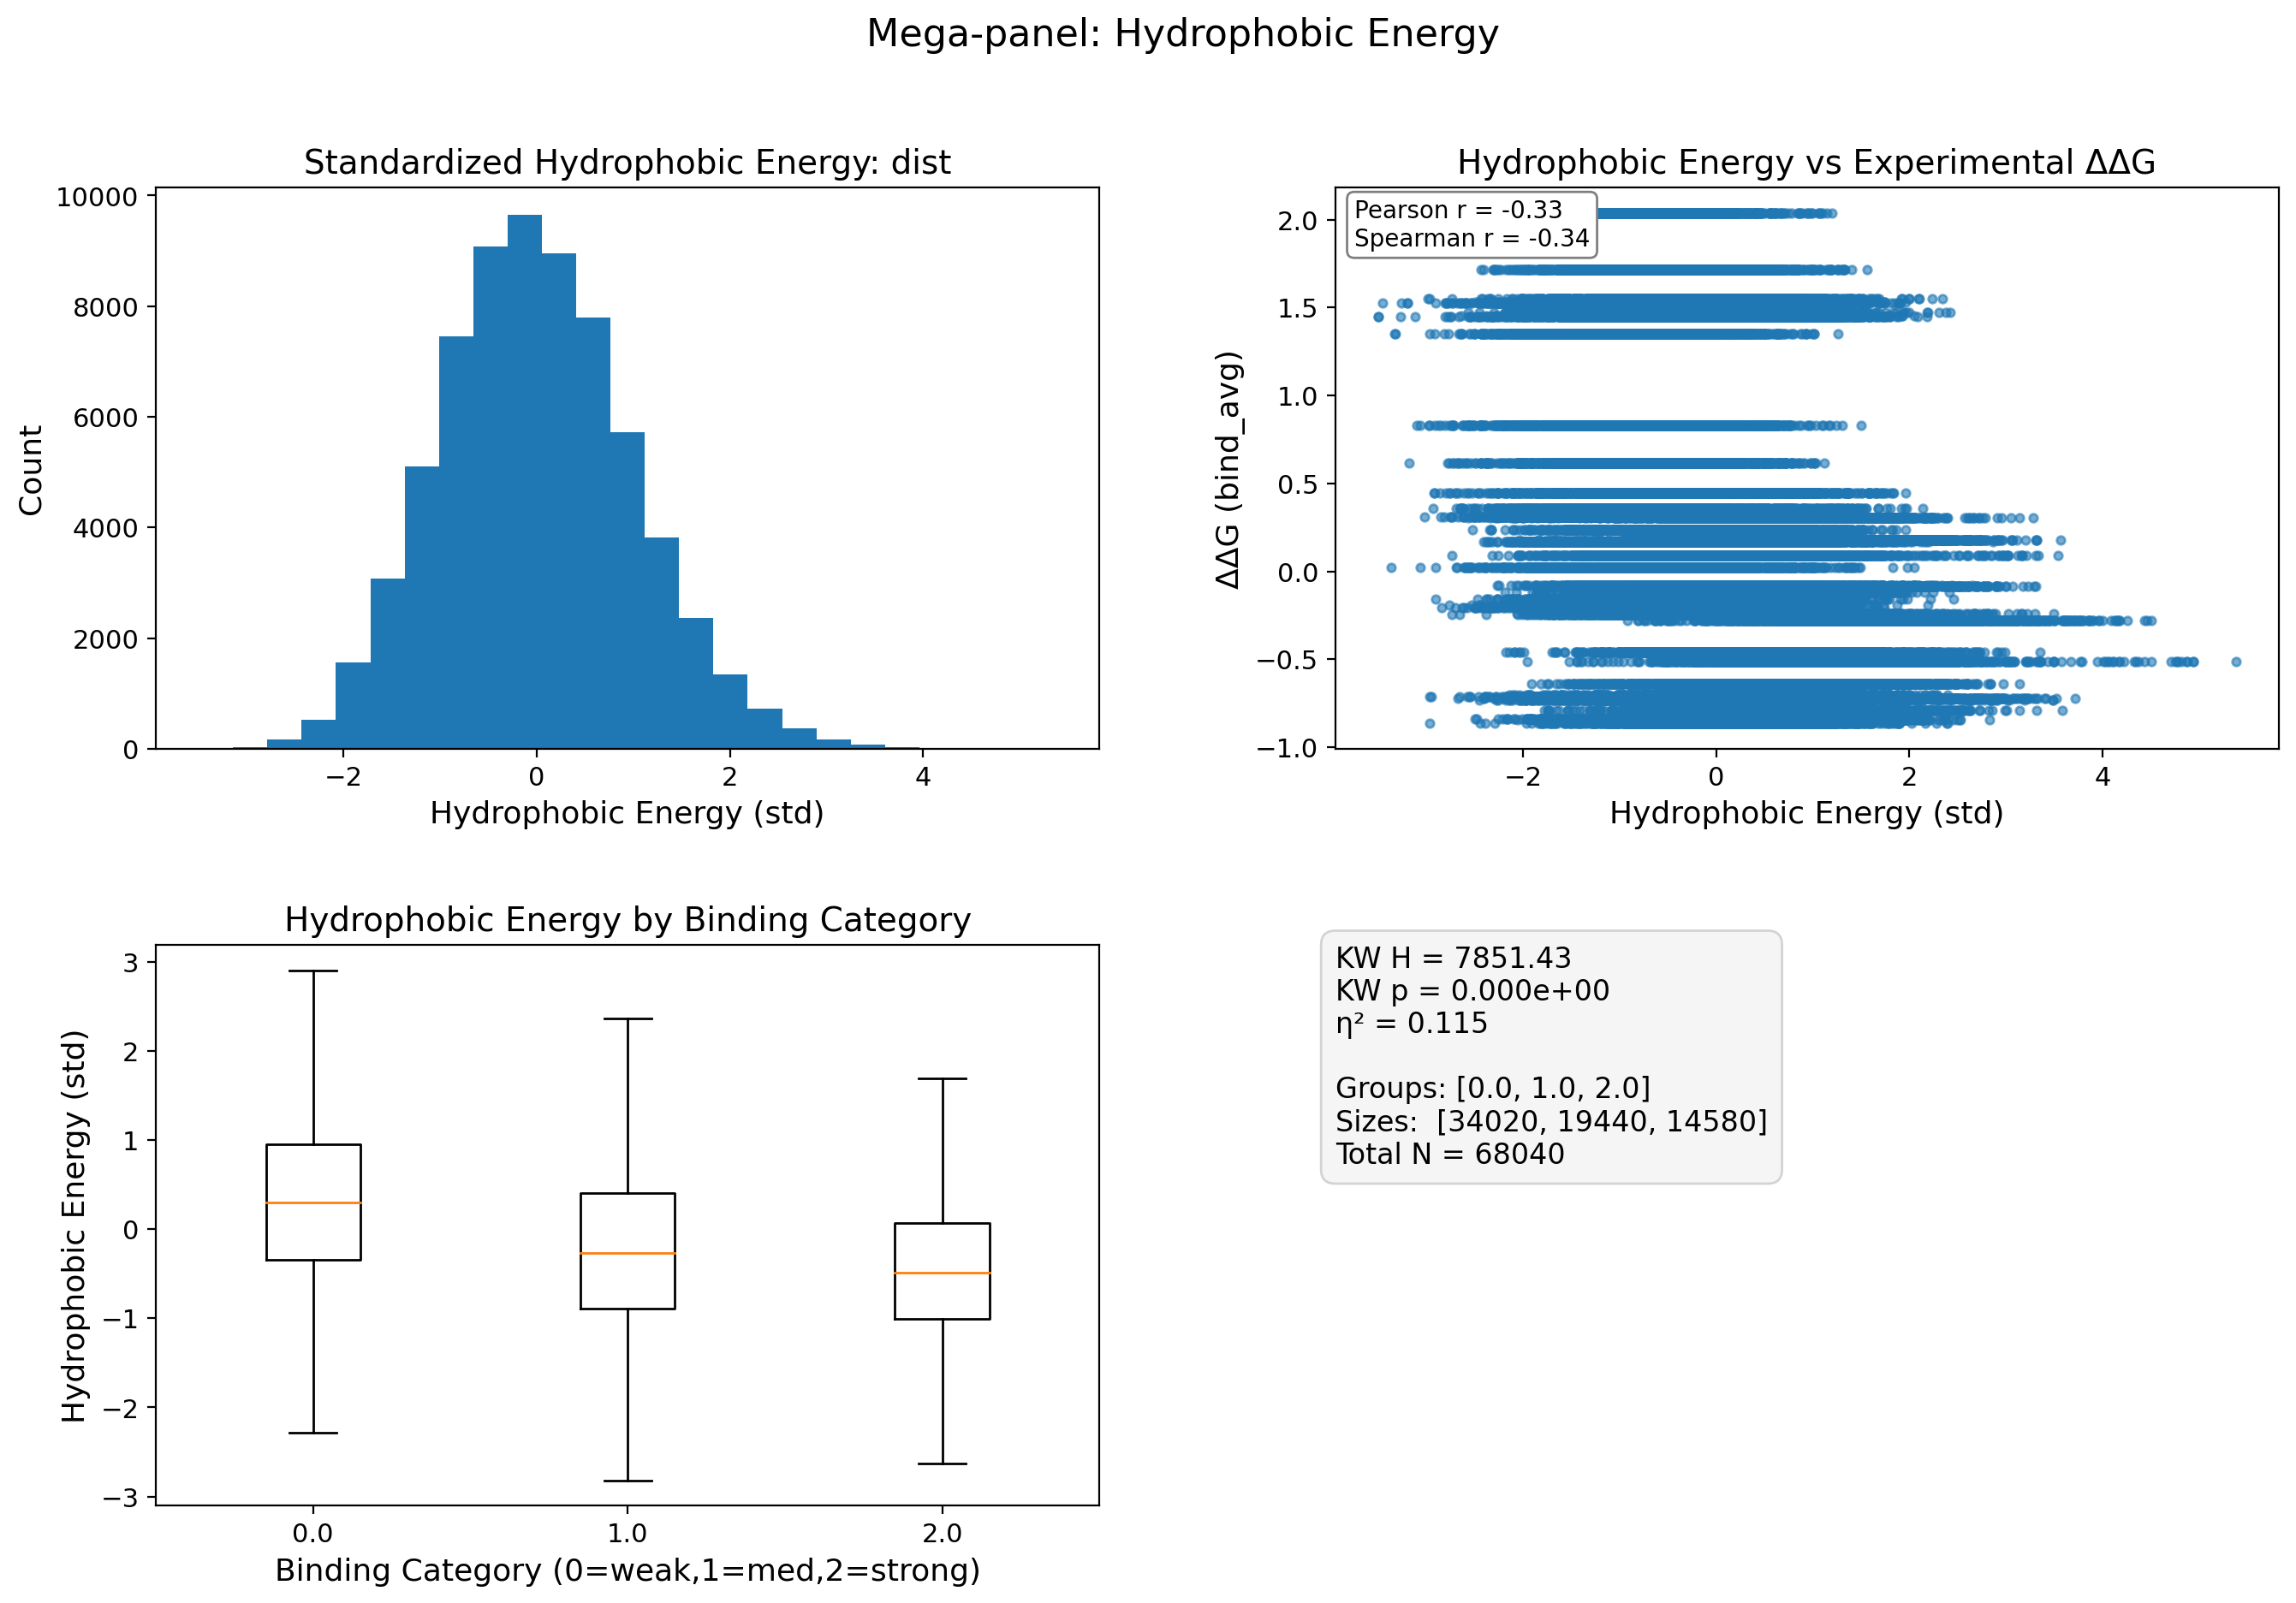

Saved: panel_Pi-Pi_Energy.png


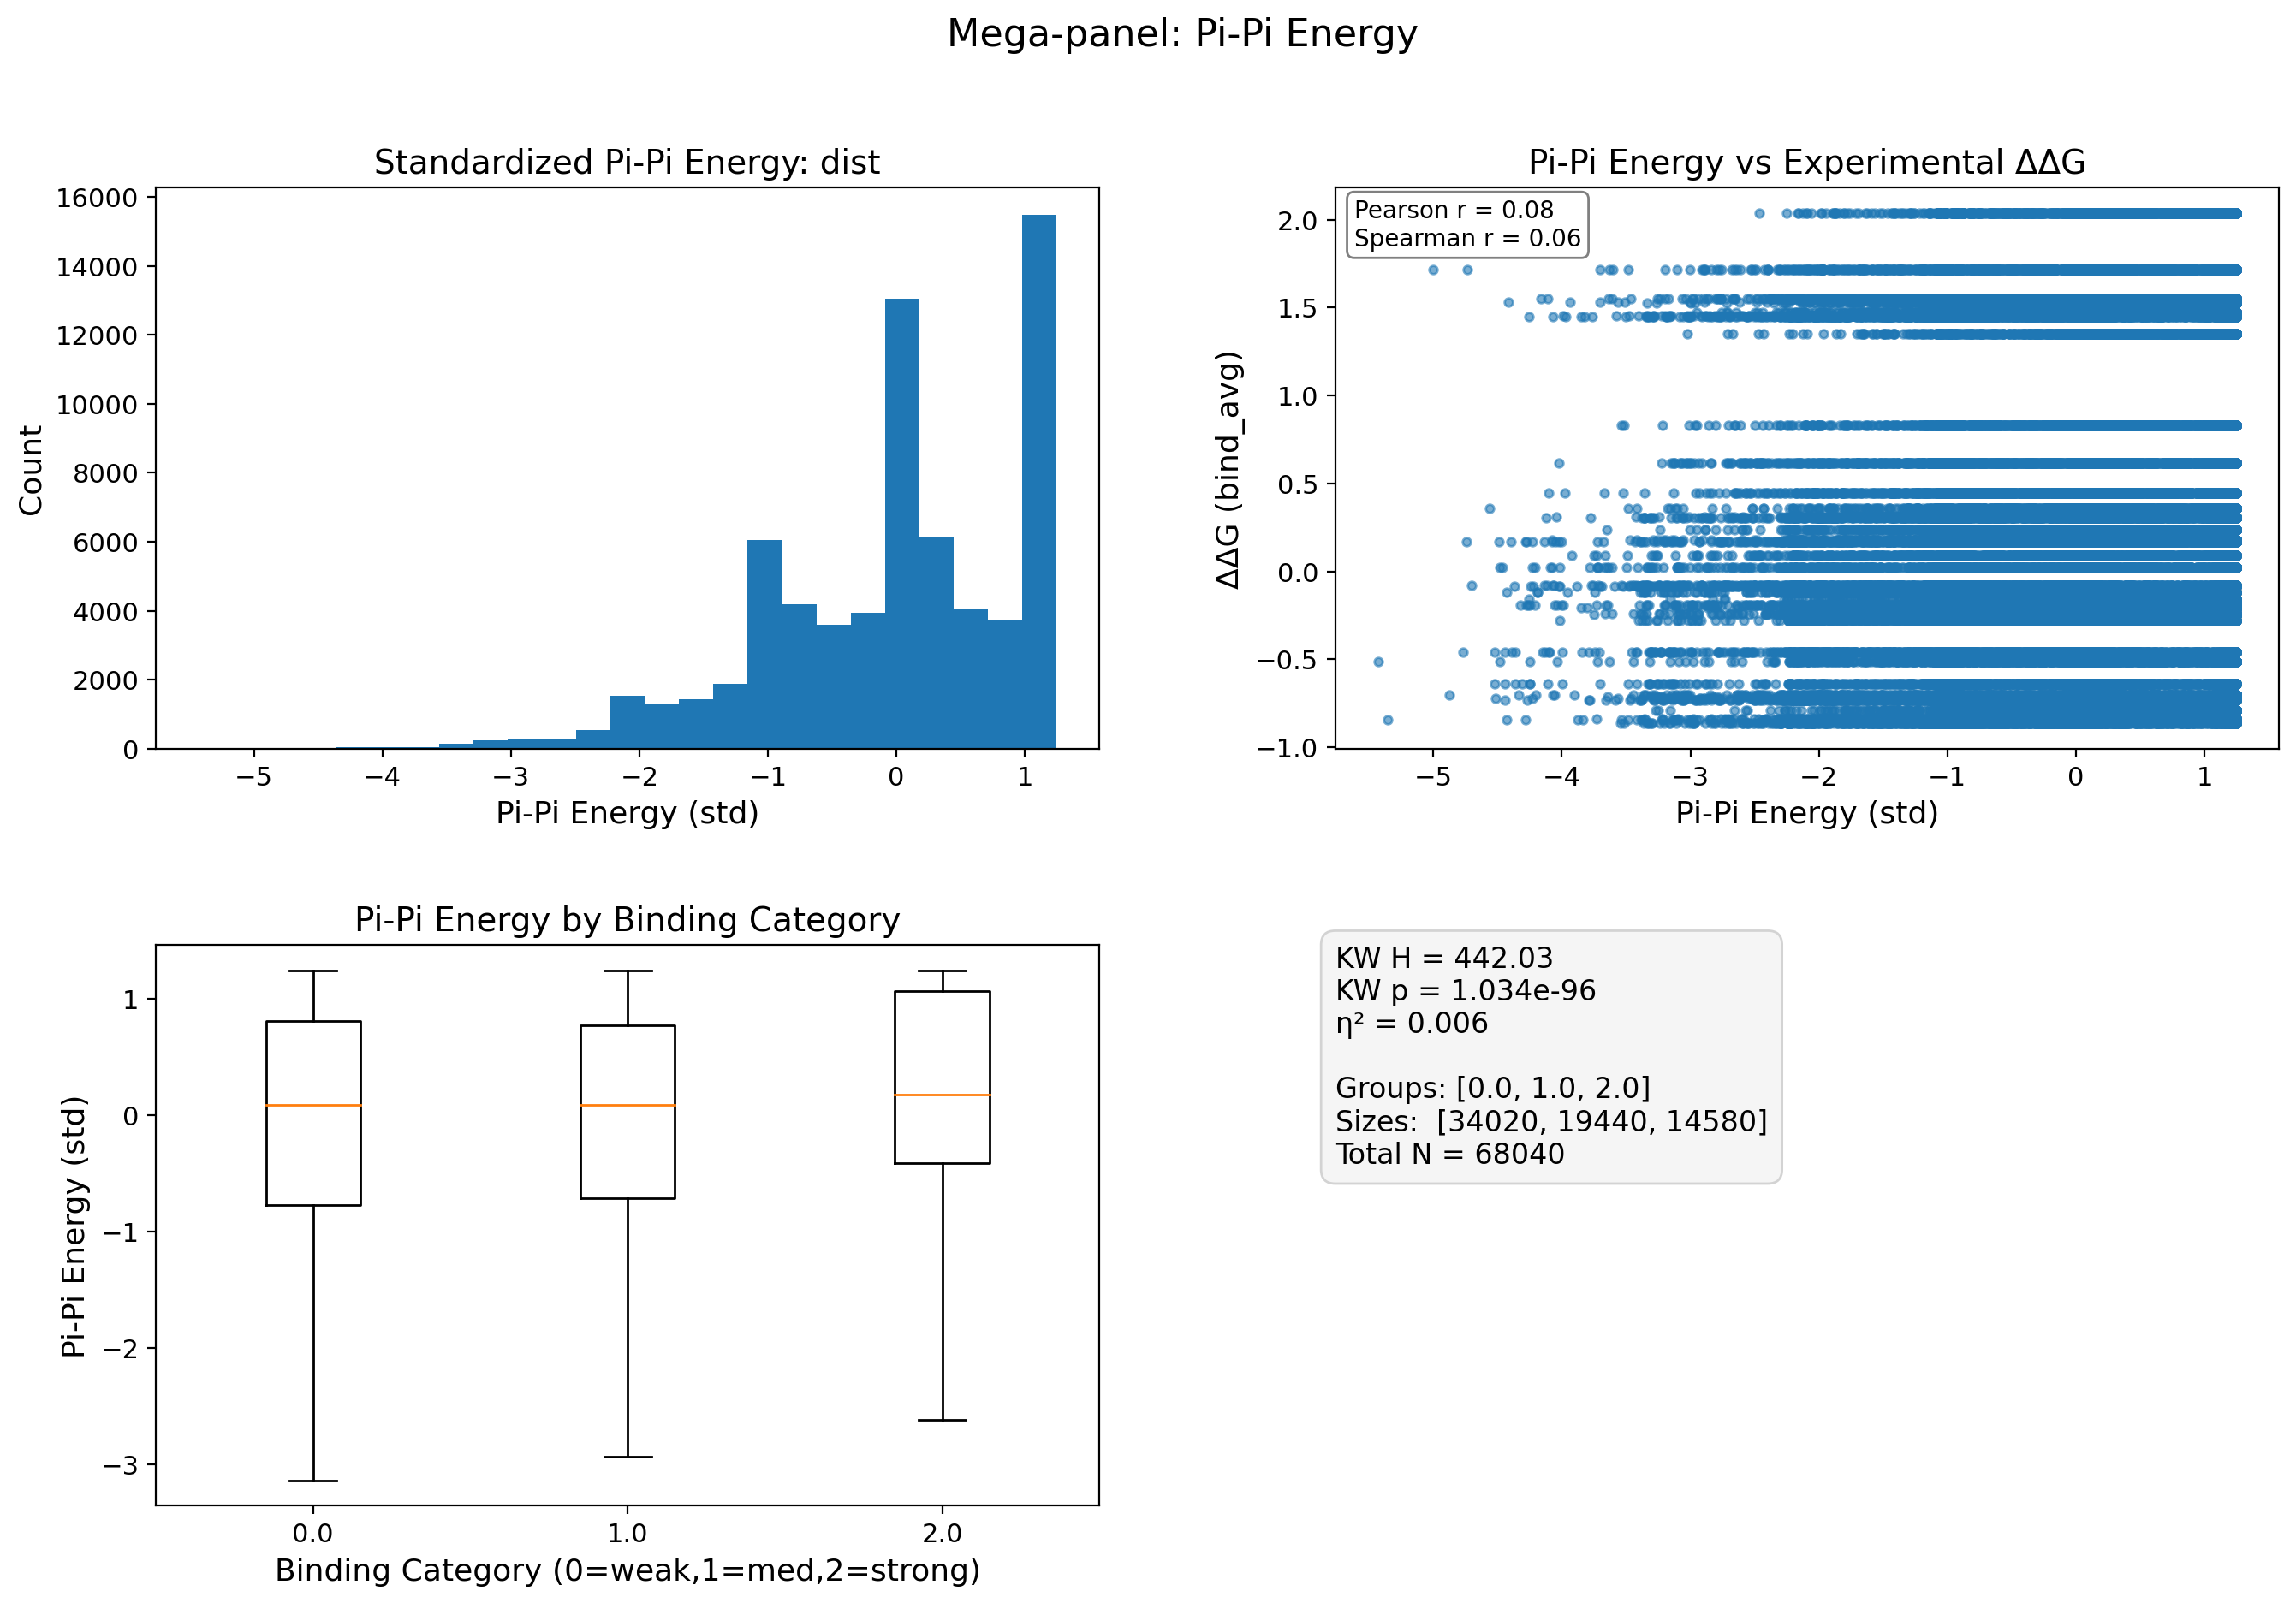

Saved: panel_Delta_Entropy.png


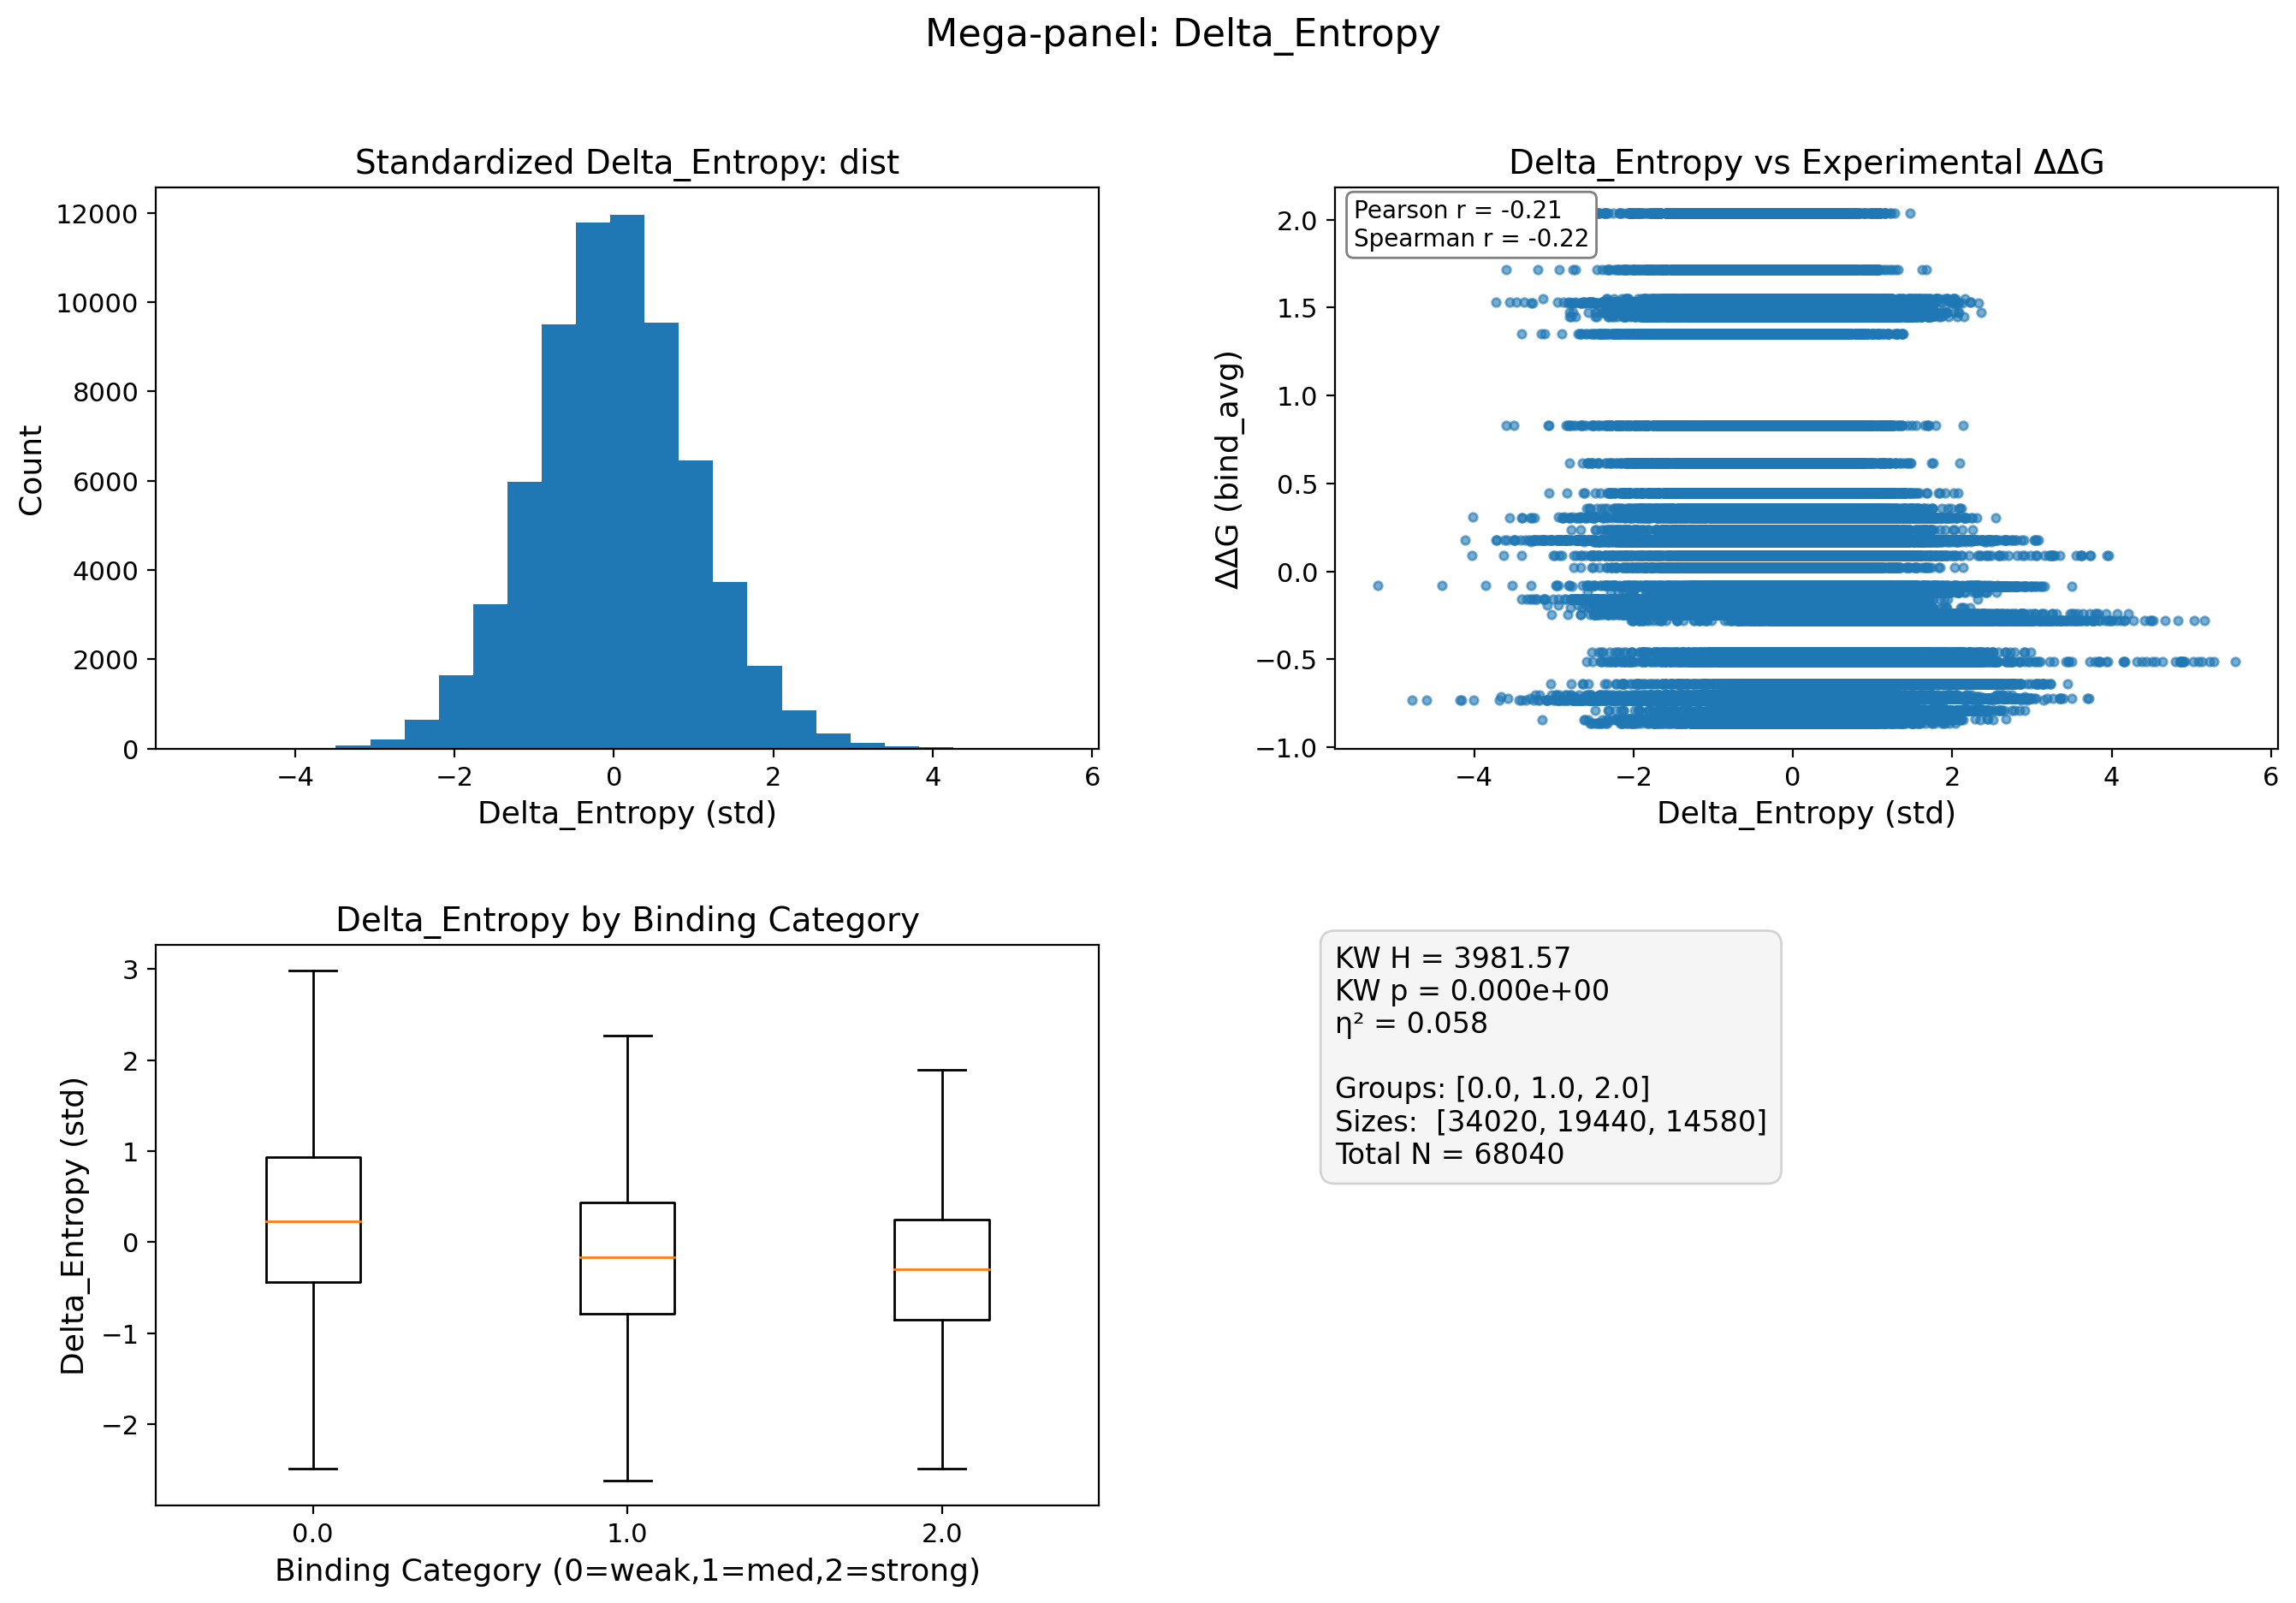

In [8]:
# EXAMPLE USAGE:
energy_terms = test1.drop(columns=['sequence','run']).columns
for term in energy_terms:
    plot_term_panel(df, term)

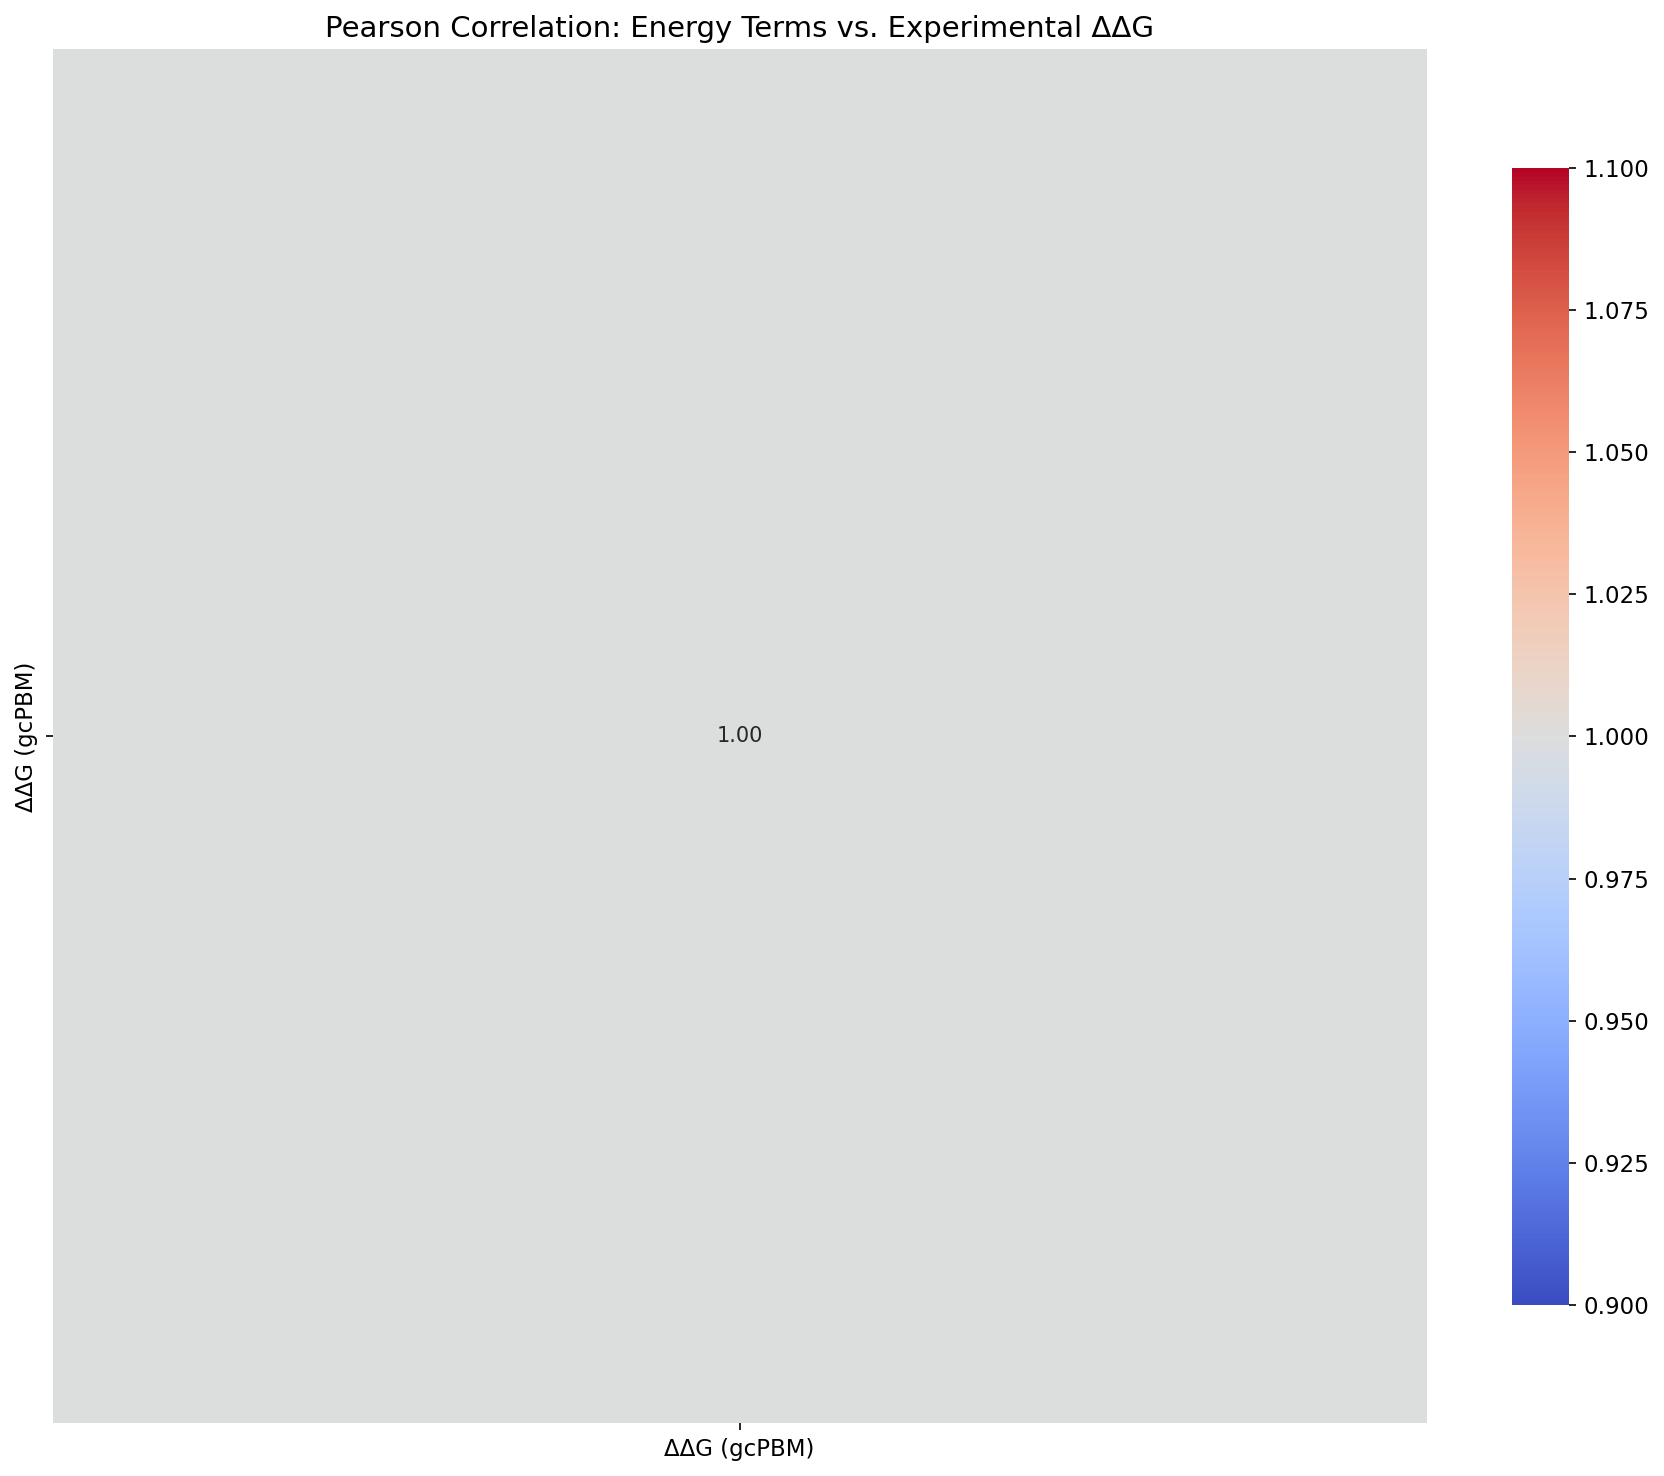

In [10]:
# 4) Correlation Heatmap of all standardized energy terms vs. experimental ΔΔG
# -----------------------------------------------------------------------------
# Build list of standardized columns that exist in df
std_cols = [f"{t} (std)" for t in energy_terms]
cols_for_corr = [c for c in std_cols + ["bind_avg"] if c in df.columns]

# Compute Pearson correlation matrix
corr = df[cols_for_corr].corr(method="pearson")

# Relabel for display
label_map = {c: ("ΔΔG (gcPBM)" if c=="bind_avg" else c.replace(" (std)","")) for c in corr.columns}
corr = corr.rename(columns=label_map, index=label_map)

plt.figure(figsize=(12,10), dpi=150)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Pearson Correlation: Energy Terms vs. Experimental ΔΔG")
plt.tight_layout()
plt.show()

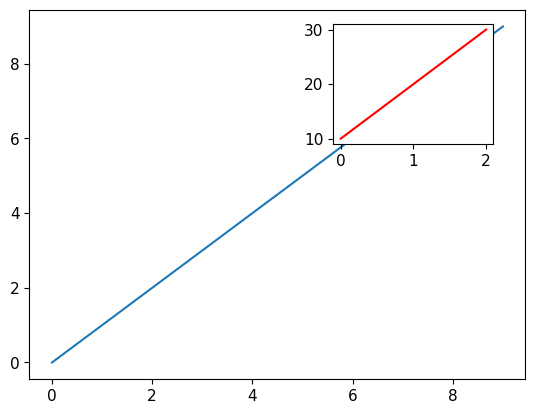

In [11]:
# Main subplot
fig, ax = plt.subplots()
ax.plot(range(10))

# Create an inset axes inside the subplot
inset_ax = plt.axes([0.6, 0.6, 0.25, 0.25])  # [left, bottom, width, height] in figure coords
inset_ax.plot([0,1,2], [10,20,30], 'r')
plt.show()